<h2>Análise exploratória e criação de modelo de Machine Learning para mercado imobiliário</h2>
<h5>Esse código é parte do trabalho final desenvolvido para o curso de Data Science e Machine Learning da Tera. A ideia é utilizar a base de lançamentos imobiliários para realizar a exploração e manipulação dos dados, bem como criar um modelo de Machine Learning. A base principal de dados utilizada nesse trabalho é o relatório de lançamentos imobiliários da Empresa Brasileira de Estudos de Patrimônio (EMBRAESP), contendo dados dos lançamentos imobiliários residenciais na Região Metropolitana de Sâo Paulo entre 1985-2013, a base foi disponibilizada pelo Centro de Estudos da Metrópole (CEM)</h5>

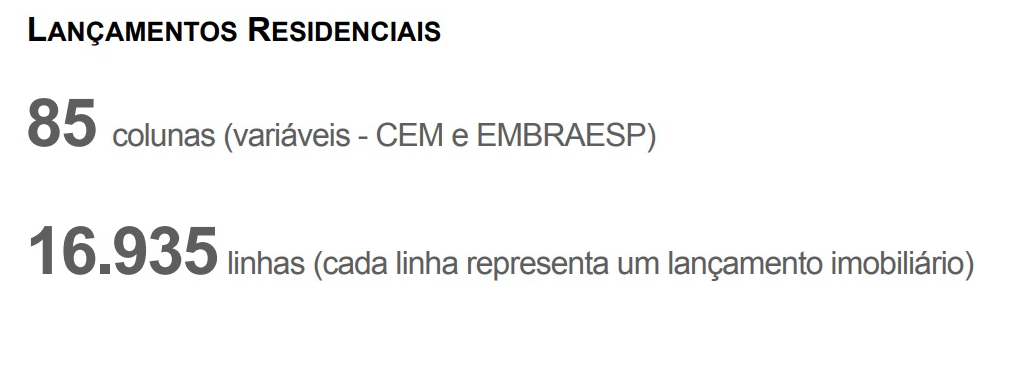
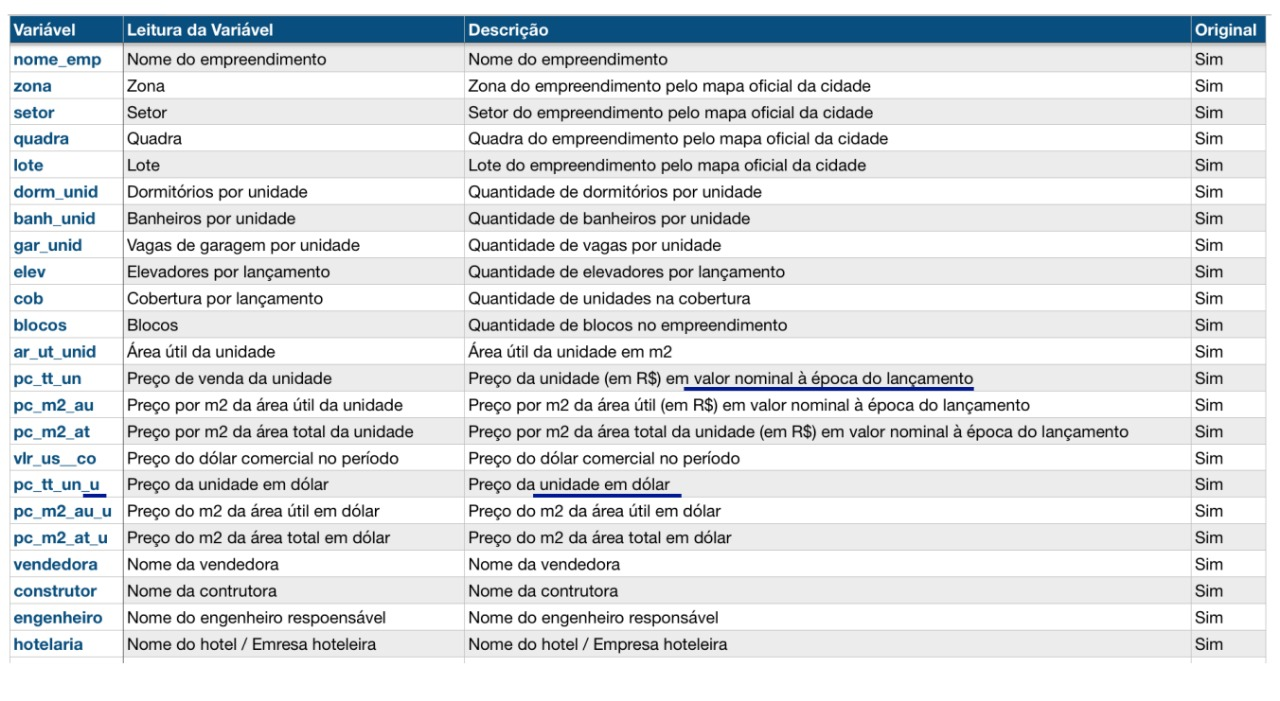
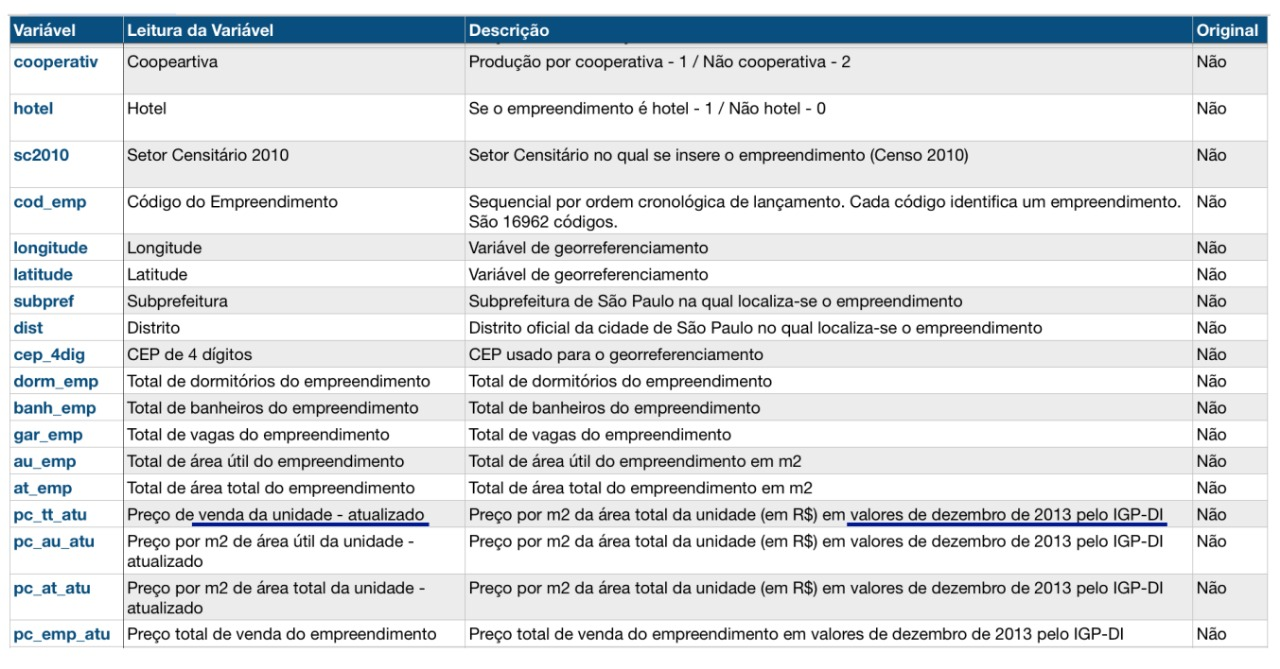
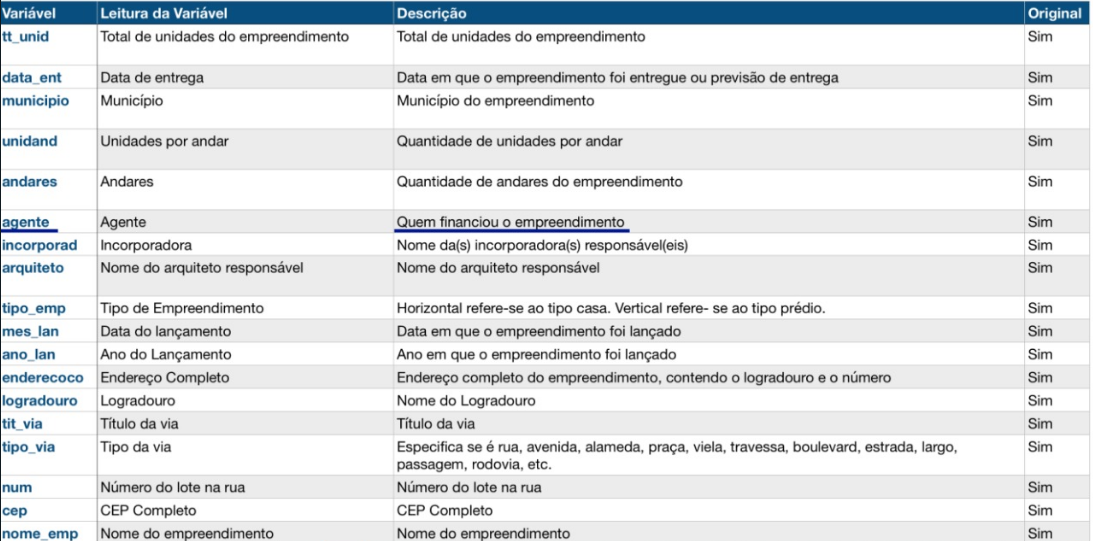
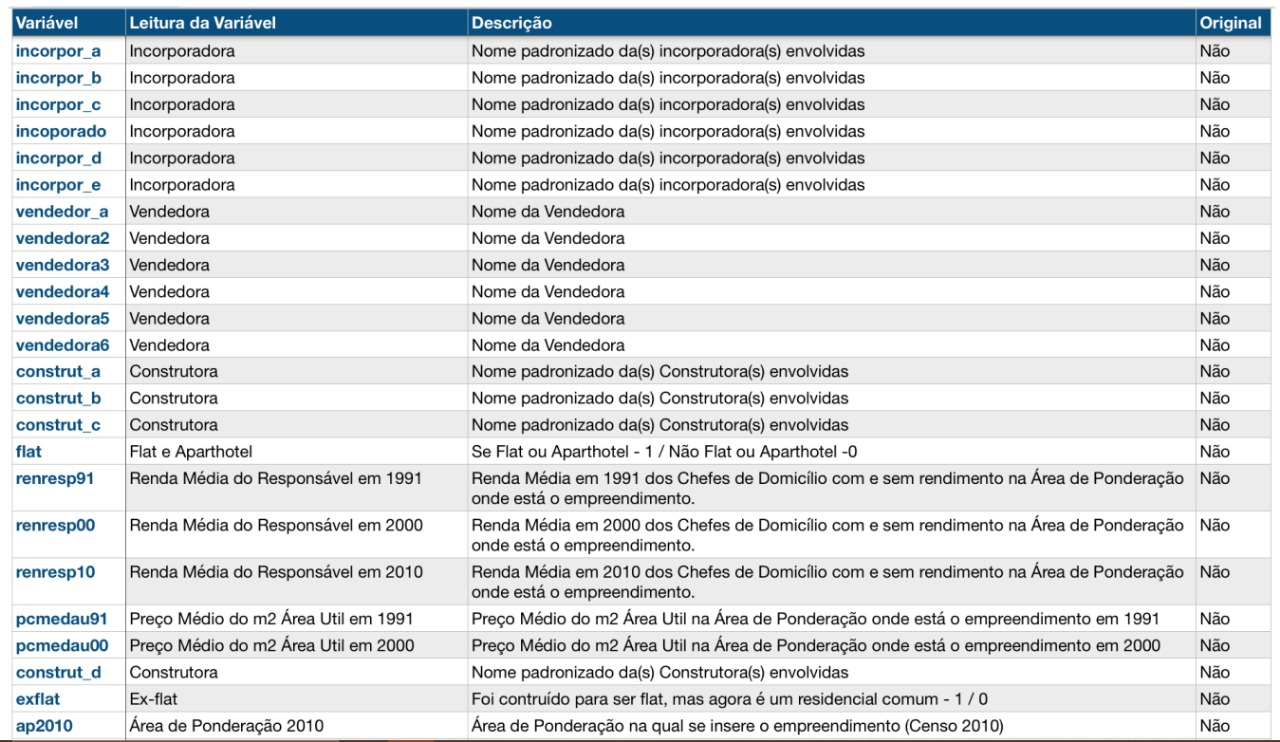

<h3>0.0 Importando as bibliotecas</h3>
<h5>Todo o trabalho de manipulação de bases é realizado principalmente através da biblioteca Pandas, sendo necessária a biblioteca Numpy em algumas ocasiões. Além dessas bibliotecas foram importadas bibliotecas para visualização dos dados</h5>

In [213]:
#Evitando alguns avisos de erros que atrapalham a leitura do código
import warnings
warnings.filterwarnings("ignore")


#Manipulação de dados
import pandas as pd
import numpy as np

#Visualização de dados
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

In [214]:
#plt.setp(axa.xaxis.get_majorticklabels(), rotation=45)

<h3>0.1 Definindo algumas funções do código</h3>
<h5>Essas são algumas funções que são definidas anteriormente porque são utilizadas recorrentemente no código ou são fruto de trabalhos anteriores</h5>

In [215]:

#Dado uma lista de colunas e um dataframe, a função plota os histogramas de cada uma das variáveis listadas
def plot_hist_variaveis(conjunto, dataframe, i=0):
    total_plots = len(conjunto)
    fig = plt.figure(figsize=(15,90), facecolor='white')
    fig.subplots_adjust(hspace=0.6, wspace=0.3)

    for var in conjunto:
        ax = fig.add_subplot(total_plots, 2, i+1)

        sns.distplot(x=dataframe[var], ax=ax, color='#435058')
        ax.axvline(x=dataframe[var].mean(), linestyle='--', color='red')
        ax.set_title(var + '. Média = {}'.format(round(dataframe[var].mean(), 2)))
        ax.set_ylabel('')
        ax.set_xlabel('')
        i += 1

#Dado uma lista de colunas e um dataframe, a função plota os boxplots de cada uma das variáveis listadas
def plot_bp_variaveis(conjunto, dataframe,resposta, i=0):
    total_plots = len(conjunto)
    fig = plt.figure(figsize=(30,90), facecolor='white')
    fig.subplots_adjust(hspace=0.2, wspace=0.3)

    for var in conjunto:
        ax = fig.add_subplot(total_plots, 2, i+1)

        sns.boxplot(x=dataframe[var], ax=ax, y=dataframe[resposta], color='#435058')
        ax.set_title(var)
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_ylim(0,np.percentile(dataframe[resposta], 98))
        plt.xticks(rotation=90)
        #plt.show()
        i += 1

#Essa função verifica o tipo das variáveis no dataframe e reduz o tamanho delas. É feita para melhorar a performance do código, uma vez que a base é extensa.
def otimiza_dataframe (dataframe):
    counter_num = 0
    counter_cat = 0
    for col in dataframe.columns:
      if dataframe[col].dtype == 'int64':
          if dataframe[col].max() < 2**7 and dataframe[col].min() > -(2**7):
            dataframe[col] = dataframe[col].astype(np.int8) 
            counter_num += 1 
          elif dataframe[col].max() < 2**15 and dataframe[col].min() > -(2**15):
            dataframe[col] = dataframe[col].astype(np.int16)  
            counter_num += 1 
          elif dataframe[col].max() < 2**31 and dataframe[col].min() > -(2**31):
            dataframe[col] = dataframe[col].astype(np.int32)  
            counter_num += 1 
          elif dataframe[col].max() < 2**63 and dataframe[col].min() > -(2**63):
            dataframe[col] = dataframe[col].astype(np.int64) 
            counter_num += 1    

      elif dataframe[col].dtype == 'float64': 
          if dataframe[col].max() < 2**31 and dataframe[col].min() > -(2**31):
            dataframe[col] = dataframe[col].astype(np.float32)
            counter_num += 1 

      elif dataframe[col].dtype == 'object':
        dataframe[col] = dataframe[col].astype('category')
        counter_cat += 1
    print('Foram otimizadas {} variáveis numéricas e  {} variáveis categóricas'.format(counter_num, counter_cat))



    

<h3>1. Lendo e ajustando as bases</h3>
<h5>A base da EMBRAESP contém, sozinha, uma série de informações úteis sobre o mercado imobiliário residencial na cidade mas, em um primeiro momento, pensou-se que pode proveitosa a conexão com algumas bases do Censo Demográfico de 2010, a fim de elaborar uma compreensão mais apurada sobre o quadro temático de onde os edifícios lançados se encontram. Todas as bases do Censo foram obtidas diretamente do diretório do Base de Dados</h5>

In [216]:
path = "LANRES_85_13_RMSP_CEM.csv"

#Obtendo o dataframe do Censo Demográfico (Básico) a partir da Base dos Dados
df_censo = pd.read_csv('CENSO_2010_TRABALHADO.csv')

#Lendo os dados da EMBRAESP
df = pd.read_csv(path, delimiter=';', decimal=',')

<h3>1.1 Pré tratamento das bases</h3>
<h5>Alguns pré-tratamentos das duas bases, envolvendo a modificação de tipos das colunas (para facilitar a intersecção posterior entre elas) e a remoção de colunas que não são consideradas úteis para a análise, além do preenchimento de valores nulos</h5>

<h4>1.1.1 - Remoção de colunas desinteressantes para o trabalho</h4>

In [217]:
#Compatibilizando os tipos da coluna que vai servir de join entre os dataframes e renomeando algumas variáveis para facilitar a interpretação
df_censo['id_setor_censitario'] = df_censo['id_setor_censitario'].astype('int64')

#Removendo colunas categóricas com dados muito fragmentados e que não oferecem boa leitura pela alto grau de cardinalidade 
df = df.drop(['NOME_EMP','CEP','SETOR', 'QUADRA', 'LOTE', 'COD_EMP', 'ENDERECOCO', 'LOGRADOURO', 'NUM','CEP_4DIG', 'ENGENHEIRO', 'ARQUITETO', 'HOTELARIA', 'INCOPORADO', 'TIT_VIA', 'PCMEDAU91', 'PCMEDAU00', 'PCMEDAU10'], axis=1)
df.info()

#Removendo colunas de incorporadora, vendedoras e construtoras secundárias no processo dos edifícios. Na maior parte das linhas só há dados 
# para os agentes primários e os agentes secundários tem muitos nulos
remover = []
for col in df.columns:
    for nome in ['INCORPOR_', 'VENDEDOR', 'CONSTRUT_']:
        remover.append(col) if nome in col and col != ('INCORPOR_A' or 'CONSTRUT_A') else None

#por algum motivo uma variável a mais entrou na lista de remoção, como não consegui encontrar a brecha no código removi a coluna da lista manualmente
remover.remove('CONSTRUT_A')
df = df.drop(remover, axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16935 entries, 0 to 16934
Data columns (total 67 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          16935 non-null  int64  
 1   TIPO_EMP    16935 non-null  object 
 2   MES_LAN     16935 non-null  object 
 3   ANO_LAN     16935 non-null  int64  
 4   DATA_ENT    16935 non-null  object 
 5   DIST        13234 non-null  object 
 6   SUBPREF     13234 non-null  object 
 7   MUNICIPIO   16935 non-null  object 
 8   TIPO_VIA    16929 non-null  object 
 9   ZONA        16935 non-null  object 
 10  DORM_UNID   16935 non-null  int64  
 11  BANH_UNID   16935 non-null  int64  
 12  GAR_UNID    16935 non-null  int64  
 13  ELEV        16935 non-null  int64  
 14  COB         16935 non-null  int64  
 15  BLOCOS      16935 non-null  int64  
 16  UNIDAND     16935 non-null  int64  
 17  ANDARES     16935 non-null  int64  
 18  AR_UT_UNID  16935 non-null  float64
 19  AR_TT_UNID  16935 non-nul

In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16935 entries, 0 to 16934
Data columns (total 53 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          16935 non-null  int64  
 1   TIPO_EMP    16935 non-null  object 
 2   MES_LAN     16935 non-null  object 
 3   ANO_LAN     16935 non-null  int64  
 4   DATA_ENT    16935 non-null  object 
 5   DIST        13234 non-null  object 
 6   SUBPREF     13234 non-null  object 
 7   MUNICIPIO   16935 non-null  object 
 8   TIPO_VIA    16929 non-null  object 
 9   ZONA        16935 non-null  object 
 10  DORM_UNID   16935 non-null  int64  
 11  BANH_UNID   16935 non-null  int64  
 12  GAR_UNID    16935 non-null  int64  
 13  ELEV        16935 non-null  int64  
 14  COB         16935 non-null  int64  
 15  BLOCOS      16935 non-null  int64  
 16  UNIDAND     16935 non-null  int64  
 17  ANDARES     16935 non-null  int64  
 18  AR_UT_UNID  16935 non-null  float64
 19  AR_TT_UNID  16935 non-nul

<h4>1.1.2 - Preenchimento de nulos</h4>

In [161]:
#As variáveis de distrito e subprefeitura só fazem menção aos locais dentro da cidade de São Paulo, então coloquei os valores nulos como "Fora de São Paulo", apenas para facilitar a manipulação posterior
df[['DIST', 'SUBPREF']] = df[['DIST', 'SUBPREF']].fillna('FORA-SP')


#Colunas numéricas que na verdade são categóricas
for col in ['COOPERATIV', 'HOTEL', 'FLAT', 'EXFLAT']:
    df[col] = df[col].astype(dtype='category')



<h3>1.2 Junção das bases e criação de novas features</h3>
<h5>A conexão das bases é realizada a partir do setor censitário, logo, as informações captadas do Censo dizem respeito a todo o setor censitário ao qual o empreendimento está inserido. Um setor censitário pode conter (e normalmente contém) mais de um empreendimento. O Censo do IBGE possui uma infinidade de variáveis e foram selecionadas apenas algumas que dão uma visão geral sobre o setor. Foram criadas variações percentuais das features incorporadas no modelo, uma vez que os números absolutos podem ser muito distintos por setor censitário.
Também foram modificadas as features de incorporadora e construtora, uma vez que apresentavam alta cardinalidade</h5>

<h4>1.2.1 - Juntando a base do censo à base principal</h4>

In [162]:
#Juntando a base da EMBRAESP e a(s) base(s) do Censo a partir dos setores censitários
df = df.join(df_censo.set_index('id_setor_censitario'), on='SC_2010', how='left')

#Os dados das colunas são pesados e a otimização dos dataframes leva em consideração o tamanho dos números em cada coluna para converter a um dtype adequado, visando diminuir o peso.
otimiza_dataframe(df)

Foram otimizadas 54 variáveis numéricas e  15 variáveis categóricas


<h4>1.2.2 - Criando novas features e modificando algumas variáveis categóricas</h4>

<h5>.1 - Censo demográfico</h5>

In [163]:

#Criando variáveis percentuais a partir das variáveis base do censo
df['PERC_ALUGADOS'] = (df['Domicilios alugados']/df['Domicílios_Setor'])*100
df['PERC_UNIPESSOAIS'] = (df['Domicilios unipessoais']/df['Domicilios no setor censitário'])*100
df['PERC_2_3_MORADORES'] = (df['Domicilios 2 ou 3 moradores']/df['Domicilios no setor censitário'])*100
df['PERC_4_MAIS_MORADORES'] = (df['Domicilios 4 ou mais moradores']/df['Domicilios no setor censitário'])*100
df['PERC_BRANCOS'] = (df['Brancos']/df['Residentes no setor censitário'])*100
df['PERC_PPI'] = ((df['Pretos'] + df['Pardos'] + df['Índigenas'])/df['Residentes no setor censitário'])*100


<h5>.2 - Incorporadoras e construtoras</h5>

In [164]:
#A cardinalidade de incorporadoras e construtoras é muito alta porque existe um mercado grande em São Paulo. Assim, agrupei as duas categorias
#A partir da soma do valor de mercado dos empreendimentos, separando entre as 50 maiores e as restantes. Cada uma das features contava originalmente com cerca
#de 500 entradas diferentes
df_incorporadoras = df.groupby(df['INCORPORAD']).sum()
df_incorporadoras = df_incorporadoras.sort_values('PC_EMP_ATU', ascending=False)
incorporadoras_maiores = df_incorporadoras.iloc[0:51]

df_construtoras = df.groupby(df['CONSTRUTOR']).sum()
df_construtoras = df_construtoras.sort_values('PC_EMP_ATU', ascending=False)
construtoras_maiores = df_construtoras.iloc[0:51]

df['INCORPORAD'] = df['INCORPORAD'].astype('string')
df['CONSTRUTOR'] = df['CONSTRUTOR'].astype('string')

#Cria a lista das maiores e menores incorporadoras
incorporadoras_maiores = incorporadoras_maiores.index.to_list()
construtoras_maiores = construtoras_maiores.index.to_list()

#Verifica, em cada linha, a qual grupo as incorporadoras pertencem
for idx, linha in df.iterrows():
    if linha['INCORPORAD'] in incorporadoras_maiores:
        df.at[idx, 'INCORPORAD'] = 'MAIORES INCORPORADORAS'
    else:
        df.at[idx, 'INCORPORAD'] = 'iNCORPORADORA MENOR'

for idx, linha in df.iterrows():
    if linha['CONSTRUTOR'] in construtoras_maiores:
        df.at[idx, 'CONSTRUTOR'] = 'MAIORES CONSTRUTORAS'
    else:
        df.at[idx, 'CONSTRUTOR'] = 'CONSTRUTORAS MENORES'


<h5>.3 - Agentes de financiamento</h5>

In [165]:
#Existem uma série de agentes que podem ter financiado o empreendimento e a escolha do agente pode influenciar diretamente
#nos preços de produção. Separei os valores entre agente públicos e privados, como uma categorização preliminar, mas distinções
#melhores são possíveis

financiamento = ['SFH', 'CEF', 'SBPE', 'CAIXA', 'BANCO DO BRASIL', 'BB', 'SBPE']

df['AGENTE'] = df['AGENTE'].astype('string')
df['AGENTE'] = df['AGENTE'].fillna('SEM INFORMAÇÃO')

for idx, linha in df.iterrows():
    if linha['AGENTE'] != 'SEM INFORMAÇÃO':
        if linha['AGENTE'].upper() in financiamento:
            df.at[idx, 'AGENTE'] = 'PUBLICO'
        else:
            df.at[idx, 'AGENTE'] = 'PRIVADO'

<h3>2. Definição das variáveis e análises visuais</h3>

<h5>É definida a variável resposta (que será utilizada posteriormente no modelo de Machine Learning), bem como as variáveis numéricas e categóricas. A definição dessas variáveis ajuda na visualização dos dados e na execução dos pipelines</h5>

In [166]:
#A variável resposta é o preço da unidade a partir do valor atualizado de 2013. 
v_resposta = "PC_TT_ATU"

#A divisão entre variáveis int e float é apenas para possíveis questões de performance
v_numericos = df.select_dtypes(include=["int8", "int16", "int32", "int64", "float"]).columns.to_list()
[v.remove(v_resposta) for v in [v_numericos]]
[v.remove('ID') for v in [v_numericos]]

v_categoricos = ['TIPO_EMP', 'DIST', 'SUBPREF', 'MUNICIPIO', 'TIPO_VIA', 'ZONA', 'SIST_FINAN', 'AGENTE']

<h4>2.1 Distribuição das variáveis categóricas</h4>

<h5>A distribuição das variáveis categóricas mostra que algumas delas, como a zona, o tipo de via e o sistema financeiro, apresentam grande variação no preço do imóvel. As duas primeiras têm relação direta com a localização do empreendimento, no caso da Zona, a diferenciação do preço do imóvel faz total sentido, uma vez que são concedidos incentivos a alguns tipos de zonas da cidade, enquantos são impostas restrições a outras delas. O alto valor nas zonas exclusivamente residenciais (ZER) pode ter relação, por exemplo, com a localização privilegiada dessas zonas em áreas mais consolidadas da cidade e com a dificuldade de disponbiilidade de terreno para verticalização nas mesmas. Por outro lado, as Zonas Especiais de Interesse Social (ZEIS), por exemplo, tem um valor de unidade muito menor, uma vez que embora tenham incentivos para construção destinam-se a criação de unidades habitacionais para grupos de baixa renda. 
O sistema financeiro impacta largamente o preço final do imóvel uma vez que definem amplamente o preço e o aporte incial do valor do imóvel. Imóveis a preço de custo, por exemplo, requerem alto investimento inicial, uma vez que os empreendedores arcam diretamente com o preço do produto. Por outro lado, imóveis consorciados tendem a ter preço de venda menor, uma vez que os valores da construção são mais diluídos</h5>

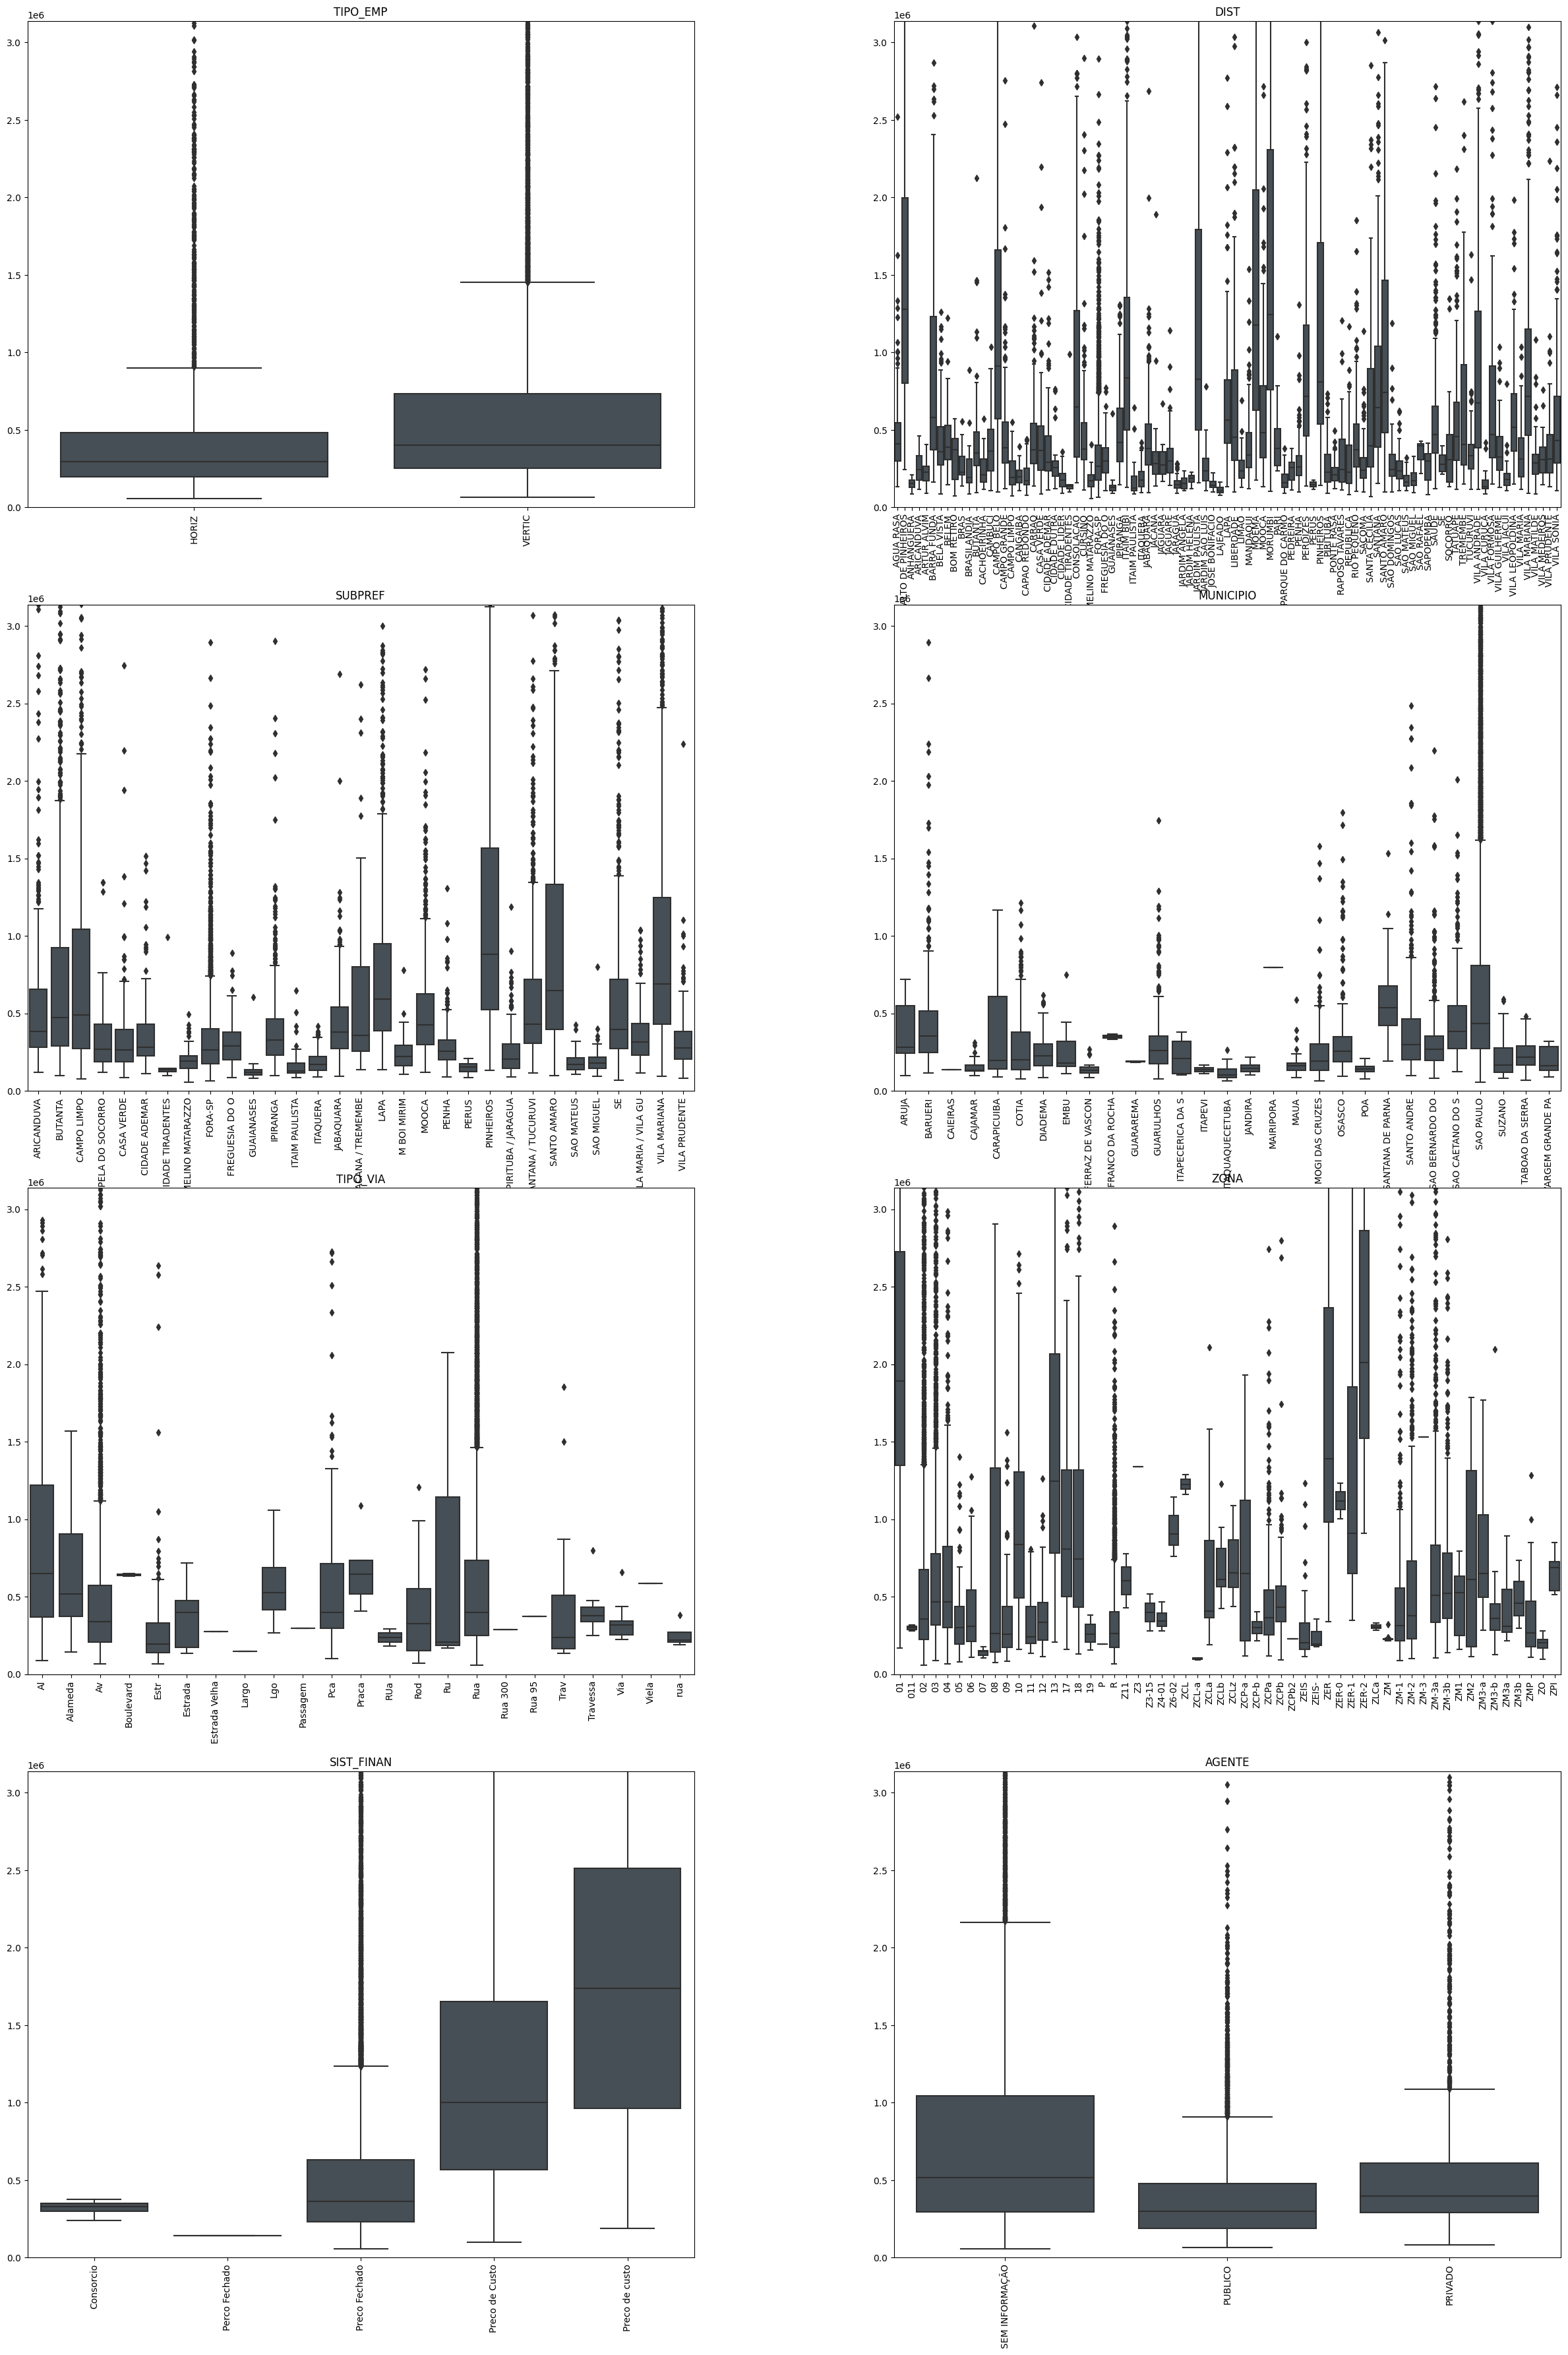

In [174]:
plot_bp_variaveis(dataframe=df, conjunto=v_categoricos, resposta=v_resposta)

<h4>2.1 Distribuição das variáveis numéricas</h4>

<h5></h5>

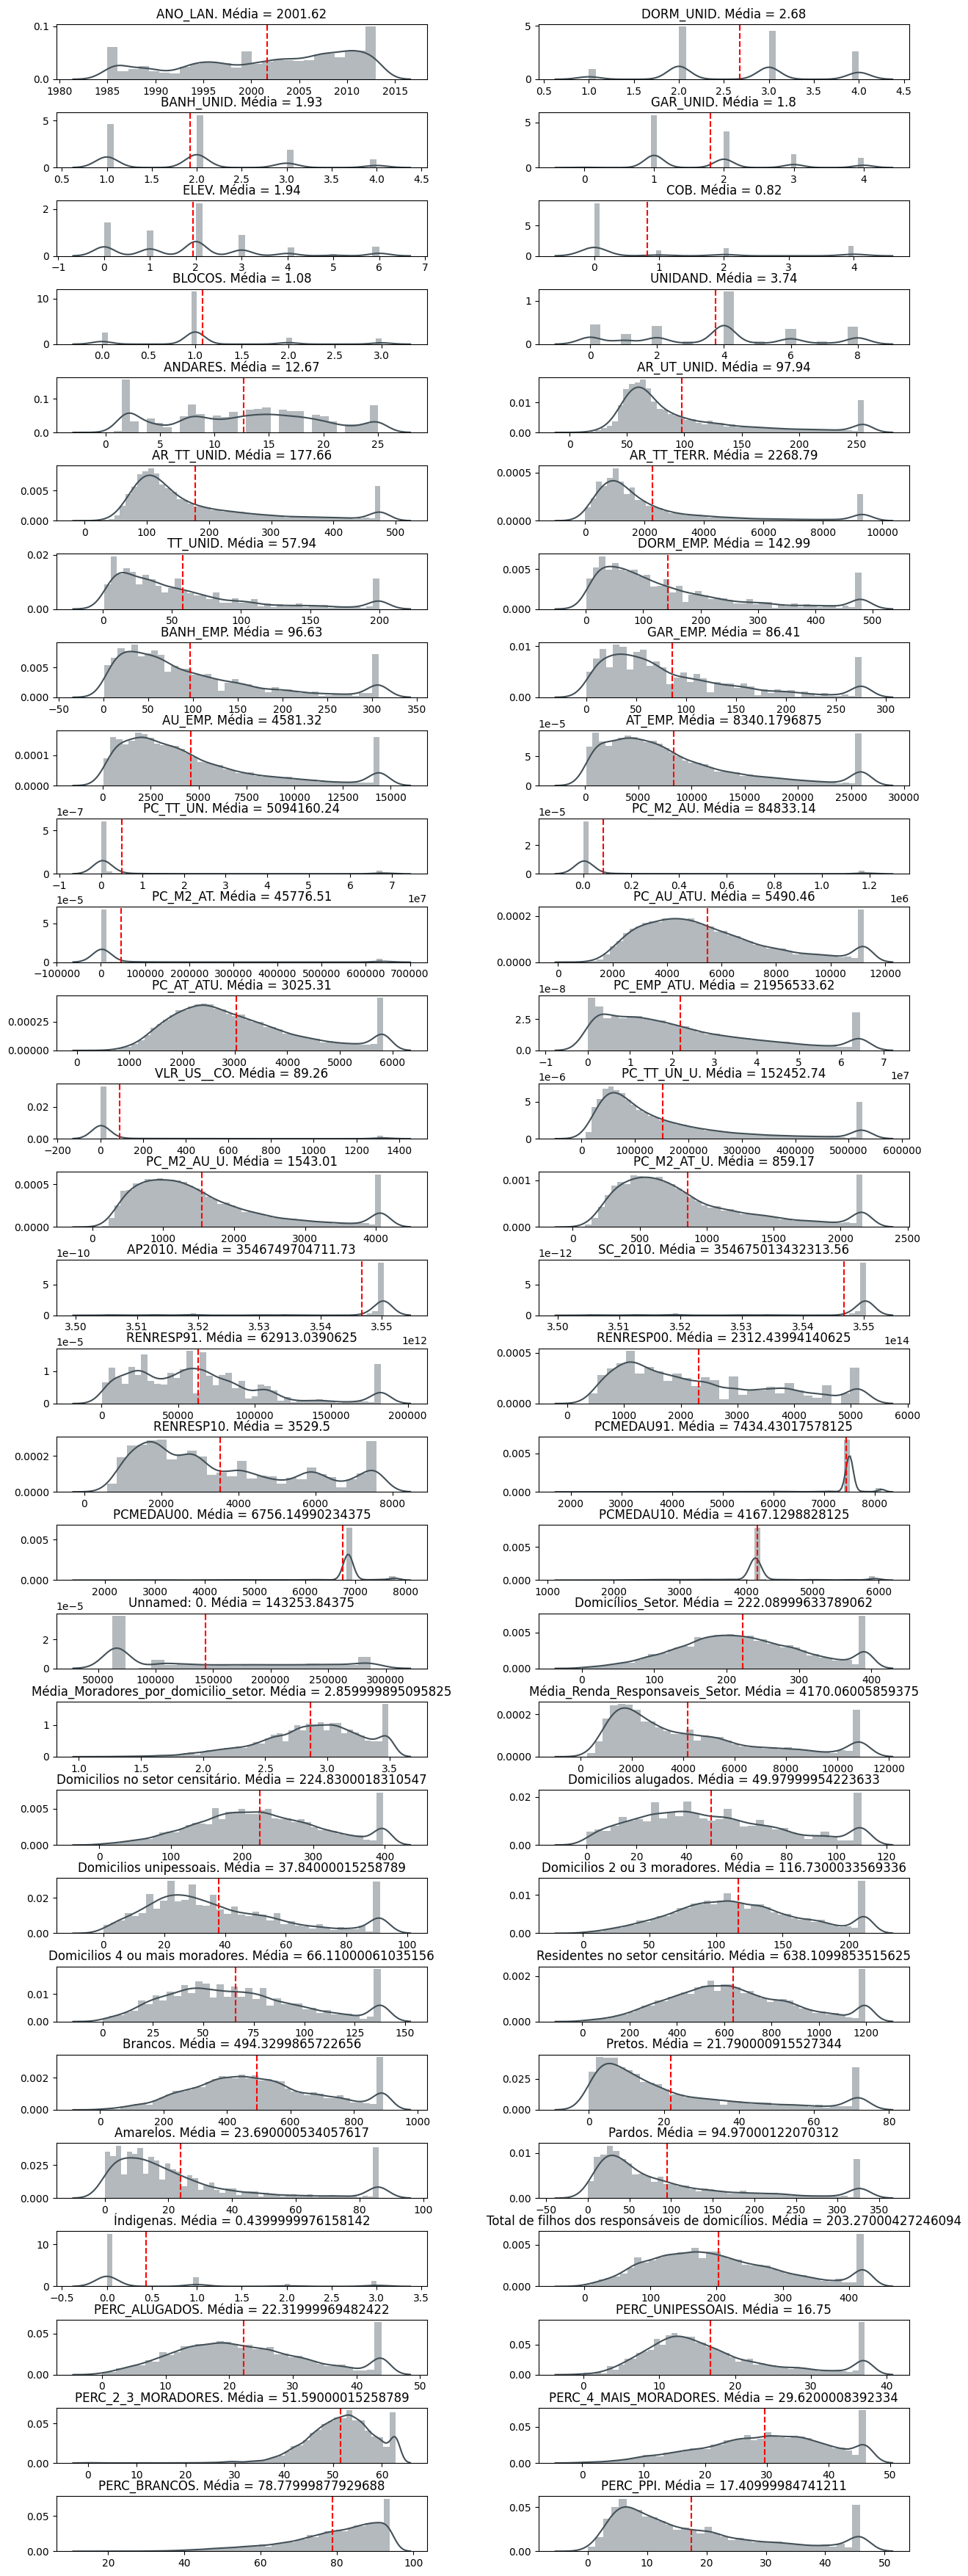

In [175]:
for col in df[v_numericos].columns:
    limite = df[col].quantile(0.95)
    df[col] = df[col].where(df[col] < limite, limite)
    
plot_hist_variaveis(v_numericos, df)

In [137]:
df[v_numericos].describe()

ANO_LAN     DORM_UNID     BANH_UNID      GAR_UNID          ELEV  \
count  16935.000000  16935.000000  16935.000000  16935.000000  16935.000000   
mean    2001.621081      2.675465      1.929200      1.804901      1.938057   
std        8.376523      0.873354      0.878335      0.967568      1.580896   
min     1985.000000      1.000000      1.000000      0.000000      0.000000   
25%     1995.000000      2.000000      1.000000      1.000000      1.000000   
50%     2003.000000      3.000000      2.000000      2.000000      2.000000   
75%     2009.000000      3.000000      2.000000      2.000000      3.000000   
max     2013.000000      4.000000      4.000000      4.000000      6.000000   

                COB        BLOCOS       UNIDAND       ANDARES    AR_UT_UNID  \
count  16935.000000  16935.000000  16935.000000  16935.000000  16935.000000   
mean       0.816120      1.083141      3.744553     12.674579     97.939367   
std        1.397905      0.725733      2.436496      6.915234     58.990681   
min        0.000000      0.000000      0.000000      0.000000     12.720000   
25%        0.000000      1.000000      2.000000      8.000000     57.680000   
50%        0.000000      1.000000      4.000000     13.000000     74.000000   
75%        1.000000      1.000000      6.000000     18.000000    120.000000   
max        4.000000      3.000000      8.000000     25.000000    256.335992   

       ...      Amarelos        Pardos     Índigenas  \
count  ...  16935.000000  16935.000000  16935.000000   
mean   ...     23.694834     94.966759      0.437201   
std    ...     23.201750     90.781860      0.879170   
min    ...      0.000000      0.000000      0.000000   
25%    ...      8.000000     29.000000      0.000000   
50%    ...     16.000000     60.000000      0.000000   
75%    ...     30.000000    128.000000      0.000000   
max    ...     86.000000    327.000000      3.000000   

       Total de filhos dos responsáveis de domicílios  PERC_ALUGADOS  \
count                                    16935.000000   16935.000000   
mean                                       203.273285      22.319389   
std                                        102.282677      10.612092   
min                                          0.000000       0.000000   
25%                                        125.000000      14.545454   
50%                                        188.000000      21.076233   
75%                                        267.000000      29.055328   
max                                        422.000000      43.925236   

       PERC_UNIPESSOAIS  PERC_2_3_MORADORES  PERC_4_MAIS_MORADORES  \
count      16935.000000        16935.000000           16935.000000   
mean          16.751110           51.594658              29.615658   
std            8.664462            6.981833              10.175331   
min            0.000000            0.000000               0.000000   
25%           10.734464           47.422680              22.857143   
50%           14.615385           52.083332              30.232557   
75%           20.809248           56.338032              37.106918   
max           37.037037           62.786003              46.067417   

       PERC_BRANCOS      PERC_PPI  
count  16935.000000  16935.000000  
mean      78.779663     17.406374  
std       12.773162     12.726471  
min       16.284510      0.000000  
25%       72.104607      7.168889  
50%       81.701447     13.370474  
75%       88.838615     24.343676  
max       93.750000     45.882786  

[8 rows x 58 columns]

In [176]:
#df_zero = df.loc[df['PC_TT_ATU'] == 0]
#df_zero.shape #118 colunas com preço da unidade igual a 0

(0, 79)

In [139]:
#df['PC_TT_UN'].replace(0,df['PC_TT_UN'].mean(axis=0),inplace=True)
#df['PC_TT_UN'].describe()

count    1.693500e+04
mean     5.129655e+06
std      1.571667e+07
min      2.460000e+04
25%      1.247115e+05
50%      2.730000e+05
75%      7.650250e+05
max      6.771115e+07
Name: PC_TT_UN, dtype: float64

<h4>2.3 Distribuição das variáveis logarítimicas</h4>
<h5>Como o plot das variáveis numéricas apontou que grande parte delas está desbalanceada com calda para direita, são feitas algumas alterações nas variáveis de preço, a fim de normalizar as distribuições. As variáveis dos valores de m² da área útil e total das unidades, bem como do preço da unidade, acabam ficando mais normalizadas</h5>

In [184]:
#Cria uma lista com as variáveis que interessam serem passadas para a forma logaritimica, bem como uma segunda lista para receber essas variáveis
v_precos = ['PC_AU_ATU', 'PC_AT_ATU', 'VLR_US__CO', 'PCMEDAU10', 'RENRESP10', v_resposta]
v_precos_log = []

#Cria as versões logaritimicas de cada variável, adiciona no datarame e na lista
for col in v_precos:
    #df[col] = df[col].where(df[col] == 0, 0.0001)
    df[col+'_log'] = np.log(df[col])
    v_numericos.append(col+'_log')
    v_precos_log.append(col+'_log')

v_resposta_log = 'PC_TT_ATU_log'

#Plota as novas variáveis
plot_hist_variaveis(v_precos_log, df)

<h3>3. Análises Bivariadas</h3>
<h5>Com as variáveis numéricas dos preços ajustadas, é interessante verificar os impactos das categorias nos valores do imóvel. A seguir são apresentadas leituras sobre os empreendimentos a partir de sua localização e período de lançamento</h5>

<h4>3.1 - Quantificando os lançamentos imobiliários por região de São Paulo</h4> 
<h5>Para facilitar a distinção geográfica, as subprefeituras de São Paulo foram agrupadas a partir de cada uma das regiões previstas pela divisão municipal</h5>
![image.png](attachment:image.png)

In [187]:
#Criando uma nova variável "REGIAO" que categoriza cada linha em sua região a partir de seu distrito
regioes = {'Centro': ['SE'],
           'Nordeste': ['CASA VERDE', 'SANTANA / TUCURUVI', 'VILA MARIA / VILA GU', 'JACANA / TREMEMBE'],
           'Noroeste': ['FREGUESIA DO O ', 'PIRITUBA / JARAGUA', 'PERUS'],
           'Oeste': ['BUTANTA', 'PINHEIROS', 'LAPA'],
           'Centro-Sul': ['VILA MARIANA', 'JABAQUARA', 'SANTO AMARO'],
           'Sul': ['CAMPO LIMPO', 'M BOI MIRIM', 'PARELHEIROS', 'CAPELA DO SOCORRO', 'CIDADE ADEMAR'],
           'Sudeste': ['IPIRANGA', 'VILA PRUDENTE', 'ARICANDUVA', 'MOOCA'],
           'Leste 1': ['PENHA', 'ERMELINO MATARAZZO', 'ITAQUERA', 'SAO MATEUS'],
           'Leste 2': ['SAO MIGUEL', 'ITAIM PAULISTA', 'GUAIANASES', 'CIDADE TIRADENTES'],
           'RMSP': ['FORA-SP']
}

regioes = {valor:chave for chave, lista in regioes.items() for valor in lista}
df['REGIAO'] = df['SUBPREF'].map(regioes)

#Dataframes com os filters de cada região, são utilizados para verificar cada região separadamente a seguir
df_sul = df.query('REGIAO == "Sul"')
df_noroeste = df.query('REGIAO == "Noroeste"')
df_nordeste = df.query('REGIAO == "Nordeste"')
df_centrosul = df.query('REGIAO == "Centro-Sul"')
df_sudeste = df.query('REGIAO == "Sudeste"')
df_leste1 = df.query('REGIAO == "Leste 1"')
df_oeste = df.query('REGIAO == "Oeste"')
df_centro = df.query('REGIAO == "Centro"')
df_leste2 = df.query('REGIAO == "Leste 2"')

<h5>3.1.1 - Verificando o valor dos empreendimentos e do m² em cada região</54>
<h5>Há um disparidade entre o número de lançamentos por região em São Paulo. As regiões oeste e centro-sul concentram a grande parte dos empreendimentos, enquanto as zonas leste e norte tiveram um número de lançamentos comparativamente muito menor. Verifica-se que os locais de maior número de lançamentos imobiliários se confundem com os de maiores valores do empreendimento e do m², de maneira semelhante, os empreendimentos lançados nas regiões norte e leste possuem valor de mercado relativamente menor</h5>


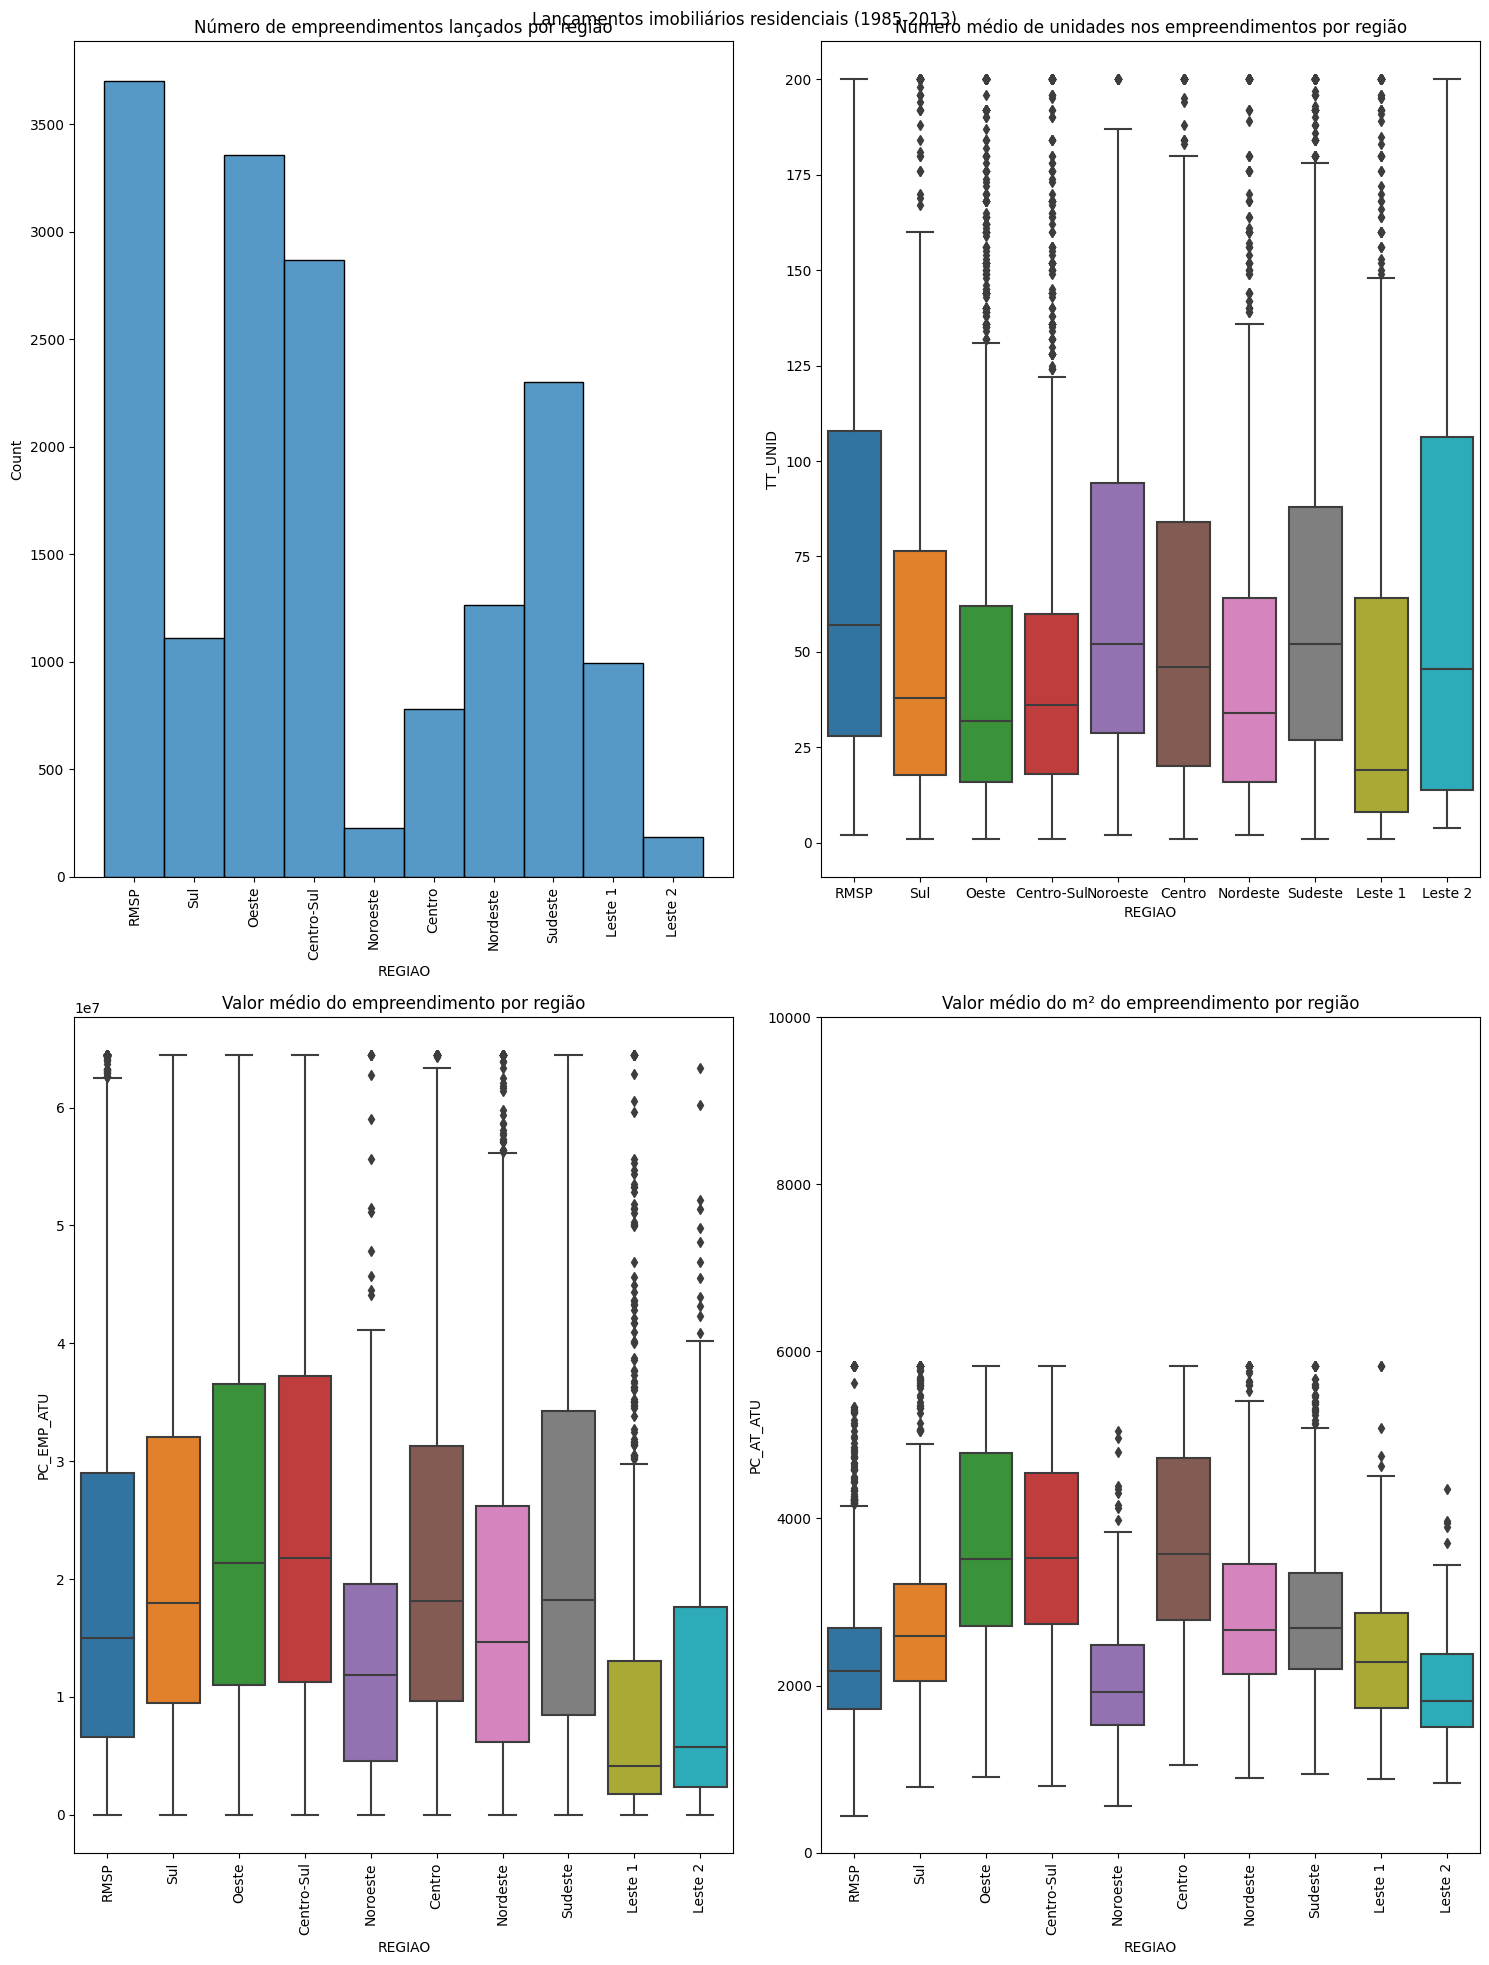

In [188]:
#Plotando as figuras dos gráficos relacionados ao valor dos empreenidmentos
fig, axs = plt.subplots(figsize=(15,20), ncols=2, nrows=2, facecolor='white')
n_emp_regiao = sns.histplot(x='REGIAO', data=df, ax=axs[0][0])
n_unid_emp = sns.boxplot(x='REGIAO', y='TT_UNID', data=df, ax=axs[0][1])
pc_emp_regiao = sns.boxplot(x='REGIAO', y='PC_EMP_ATU', data=df, ax=axs[1][0])
pc_m2_regiao = sns.boxplot(x='REGIAO', y='PC_AT_ATU', data=df, ax=axs[1][1])

n_emp_regiao.set_title('Número de empreendimentos lançados por região')
n_unid_emp.set_title('Número médio de unidades nos empreendimentos por região')
pc_emp_regiao.set_title('Valor médio do empreendimento por região')
pc_m2_regiao.set_title('Valor médio do m² do empreendimento por região')

plt.xticks(rotation=90)
n_emp_regiao.tick_params('x', labelrotation=90)
pc_emp_regiao.tick_params('x', labelrotation=90)
pc_m2_regiao.set_ylim(0,10000)

plt.suptitle('Lançamentos imobiliários residenciais (1985-2013)')
plt.tight_layout()

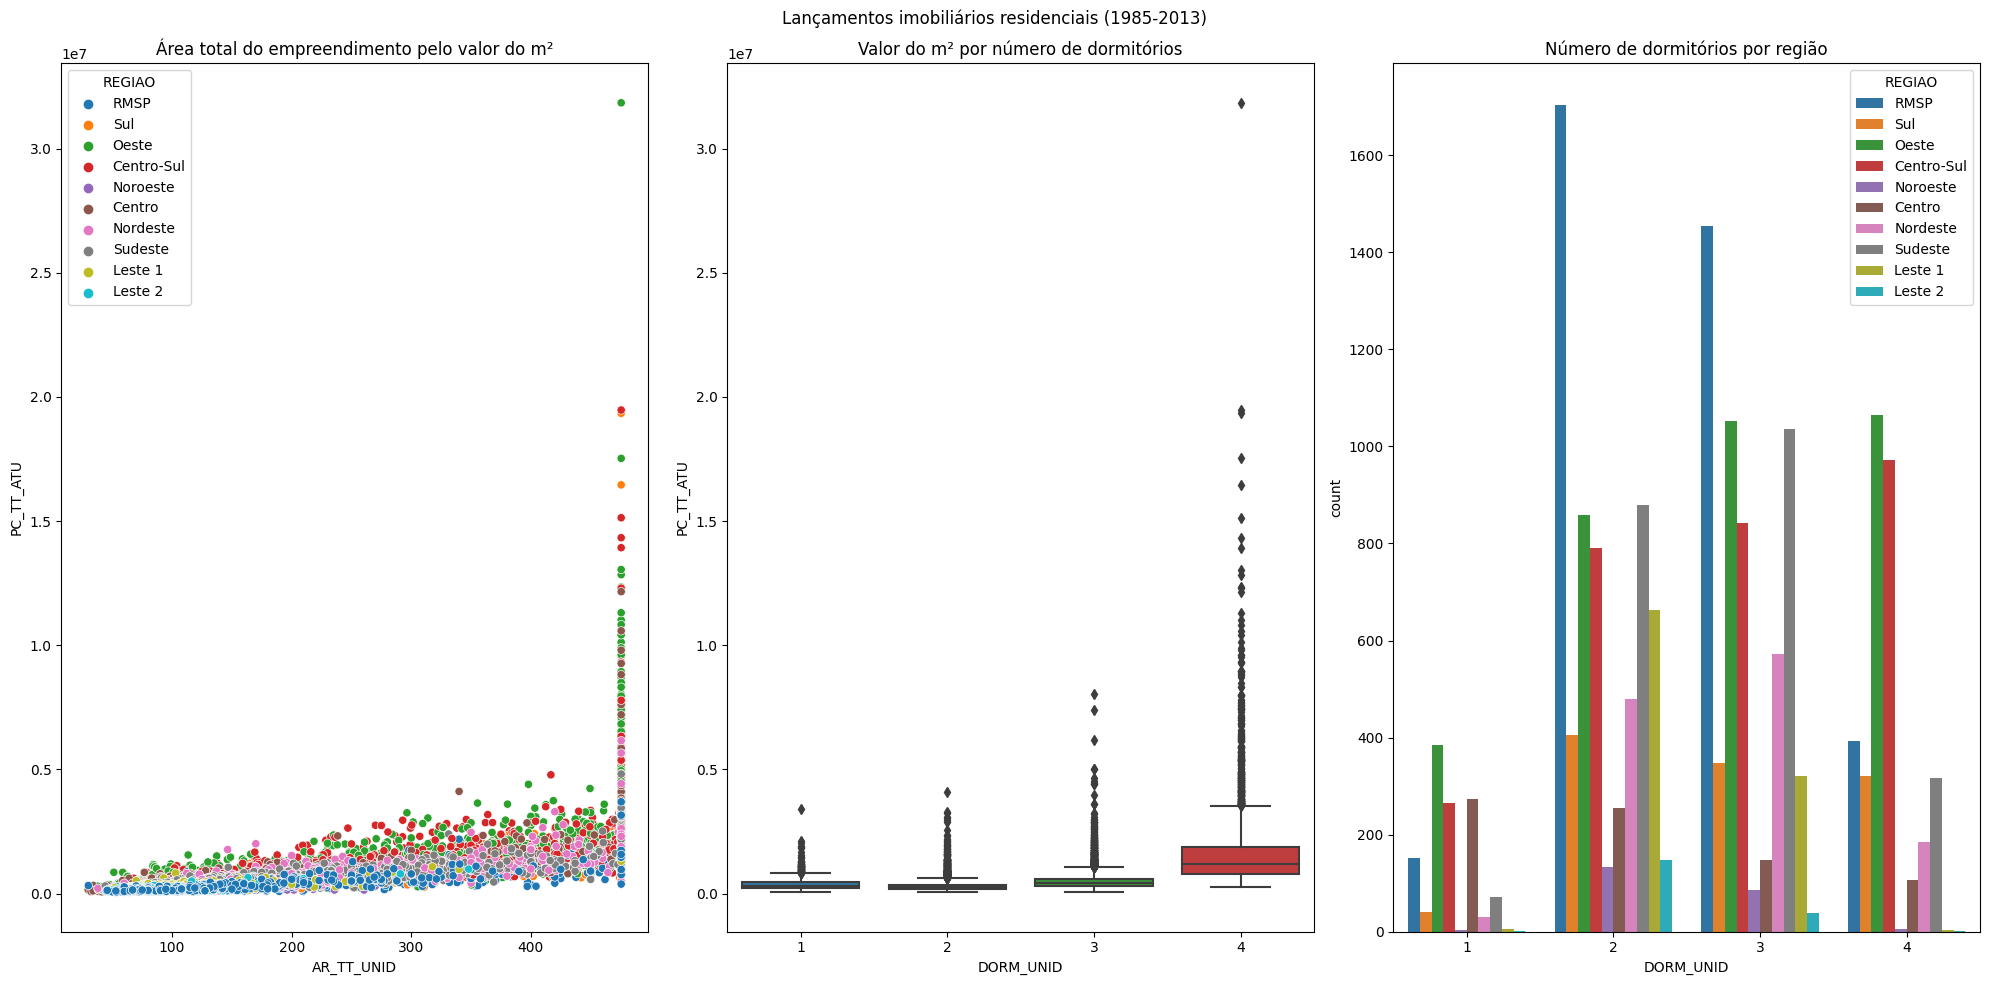

In [145]:
fig, axs = plt.subplots(figsize=(20,10), ncols=3, nrows=1, facecolor='white')
area_pc = sns.scatterplot(x='AR_TT_UNID', y=v_resposta, hue='REGIAO', data=df, ax=axs[0])
m2_dorm = sns.boxplot(x='DORM_UNID', y=v_resposta, data=df, ax=axs[1])
pc_m2_regiao = sns.countplot(x=df['DORM_UNID'], hue='REGIAO', data=df)

axs[0].set_title('Área total do empreendimento pelo valor do m²')
axs[1].set_title('Valor do m² por número de dormitórios')
axs[2].set_title('Número de dormitórios por região')

plt.suptitle('Lançamentos imobiliários residenciais (1985-2013)')
plt.tight_layout()

In [147]:
#Função que plota 
def m2_dorm_regiao (lista_dataframes):
    for i, dataframe in enumerate(lista_dataframes):
        fig, axs = plt.subplots(figsize=(20,10), ncols=3, nrows=1, facecolor='white')
        area_pc_regiao = sns.scatterplot(x='AR_TT_UNID', y=v_resposta, hue='REGIAO', data=dataframe, ax=axs[0])
        dorm_unid_pc_box = sns.boxplot(x='DORM_UNID', y=v_resposta, data=dataframe, ax=axs[1])
        num_dorm = sns.countplot(x='DORM_UNID', hue='REGIAO', data=dataframe)

        axs[0].set_title('Área total da unidade pelo valor do m²')
        axs[1].set_title('Valor do m² por número de dormitórios')
        axs[2].set_title('Número de dormitórios por região')

        axs[0].set_ylim(0, 6000)
        axs[1].set_ylim(0, 10000)
        axs[2].set_ylim(0, 1500)
        plt.xticks(rotation=90)
        plt.suptitle('Lançamentos imobiliários residenciais (1985-2013) em {}'.format(dataframe['REGIAO'].mode()))
        plt.tight_layout()

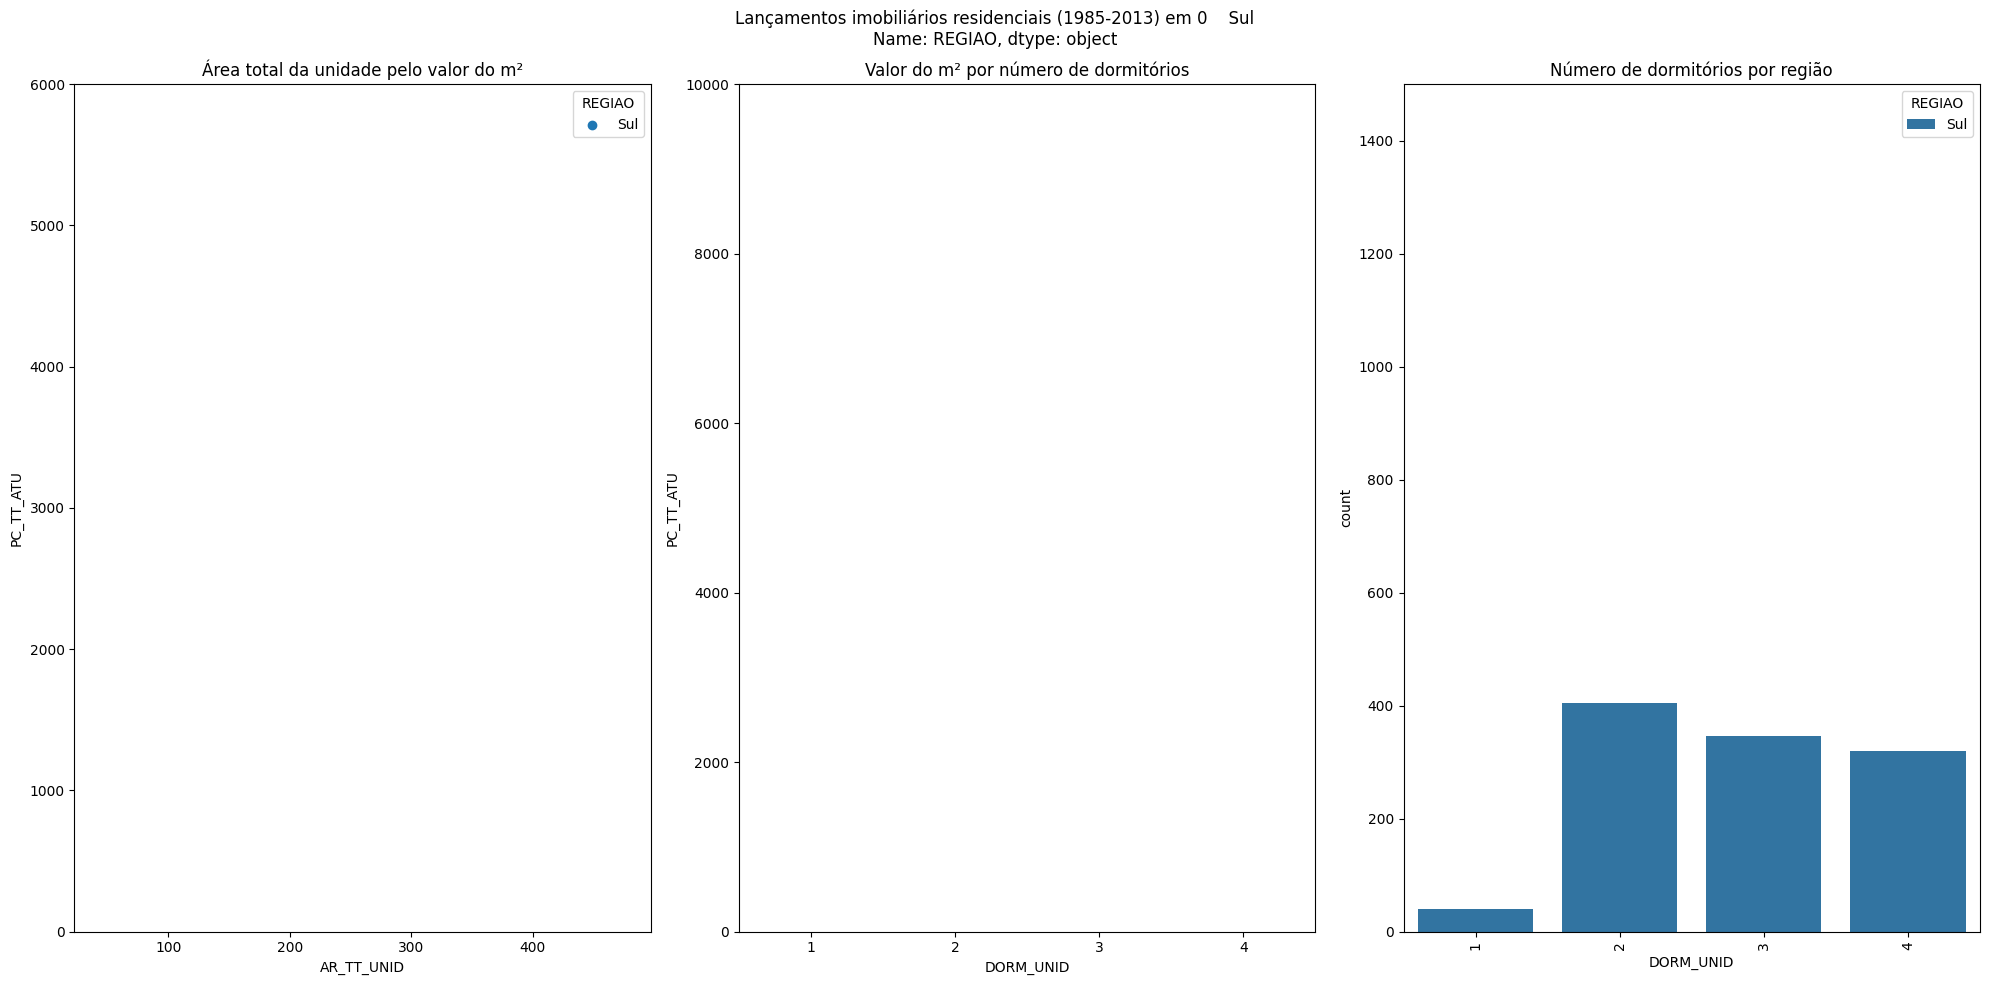

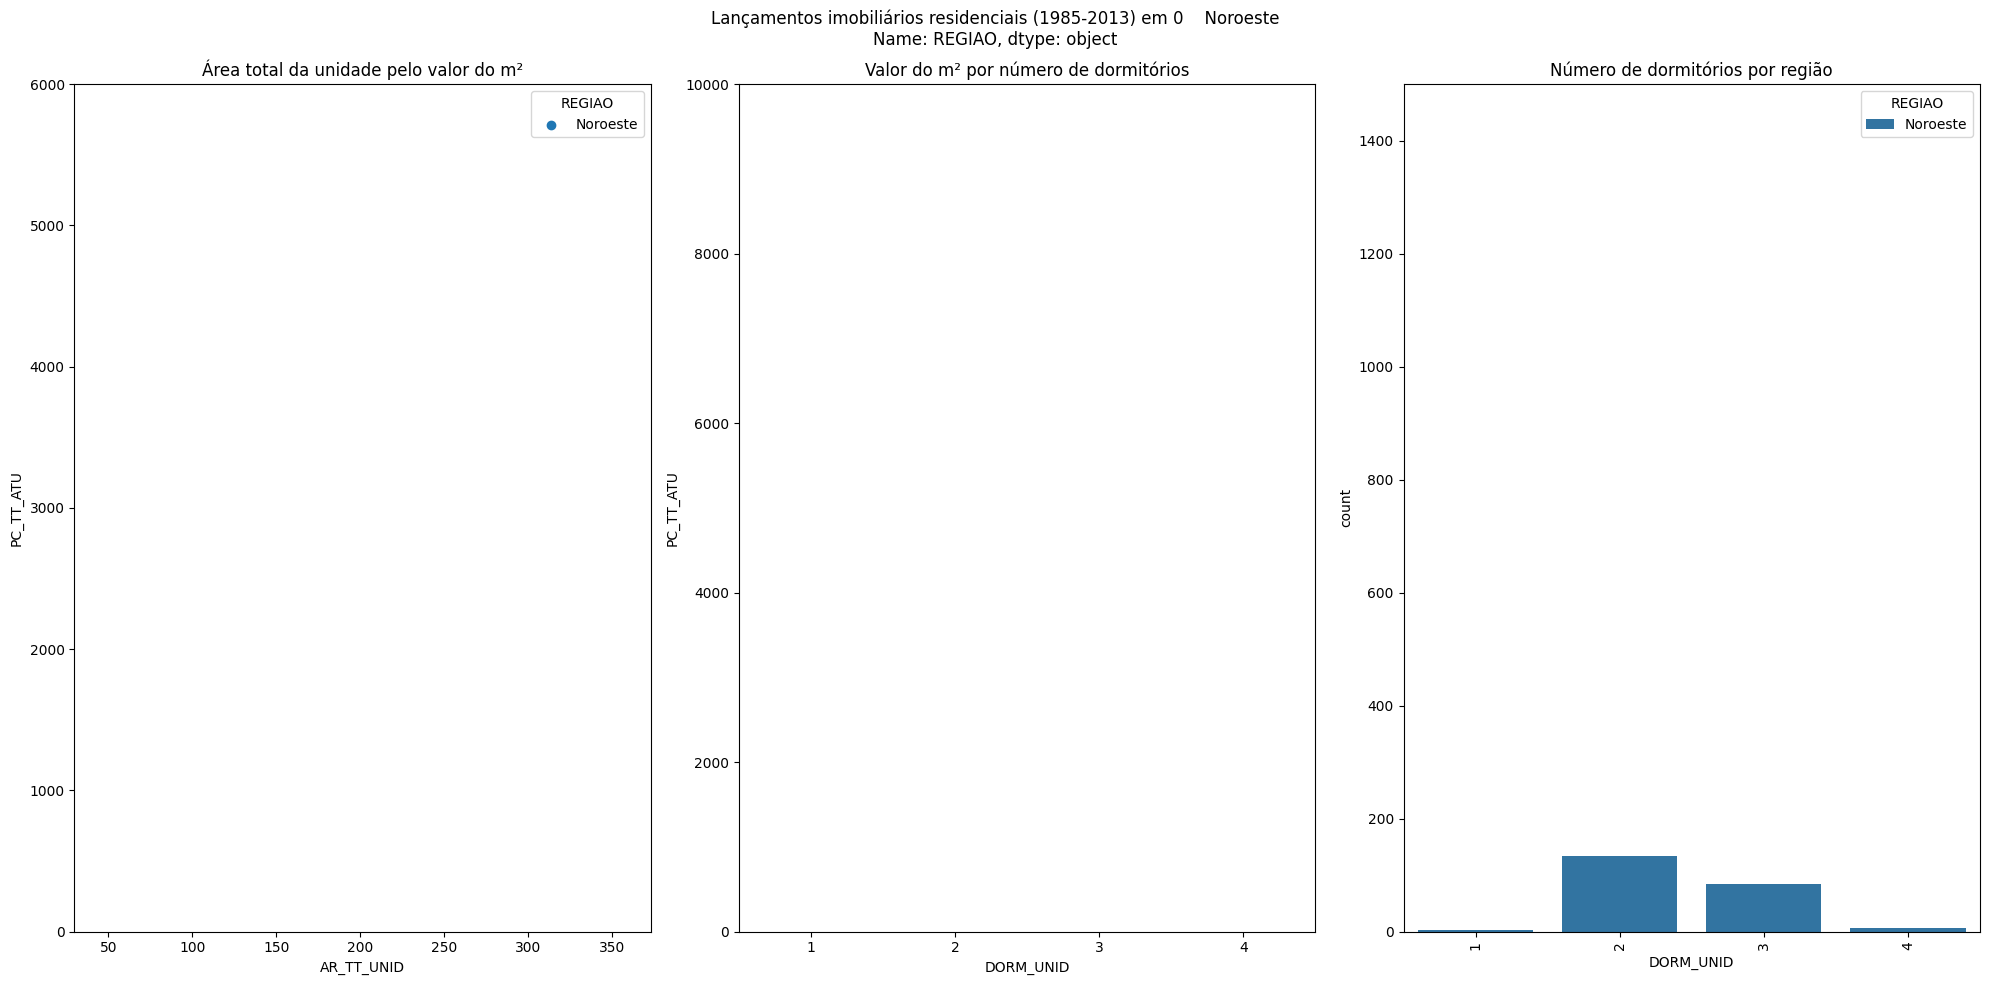

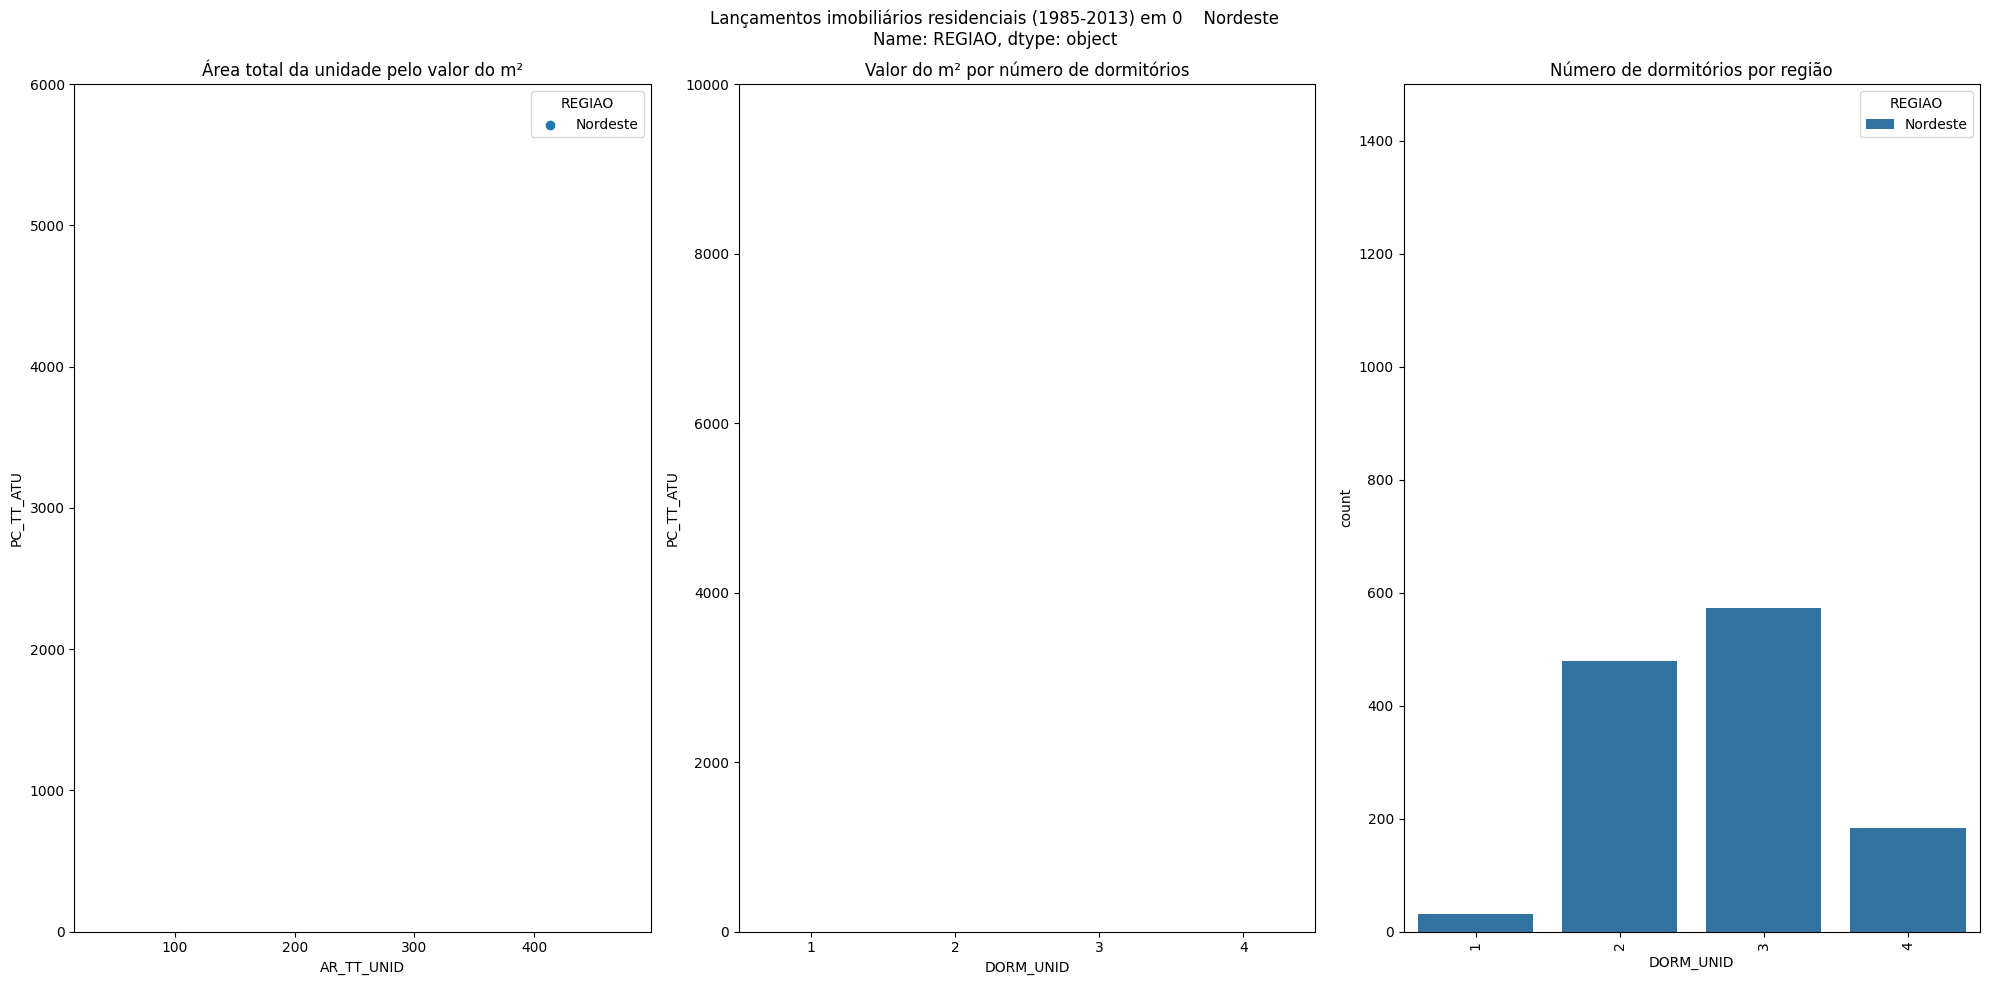

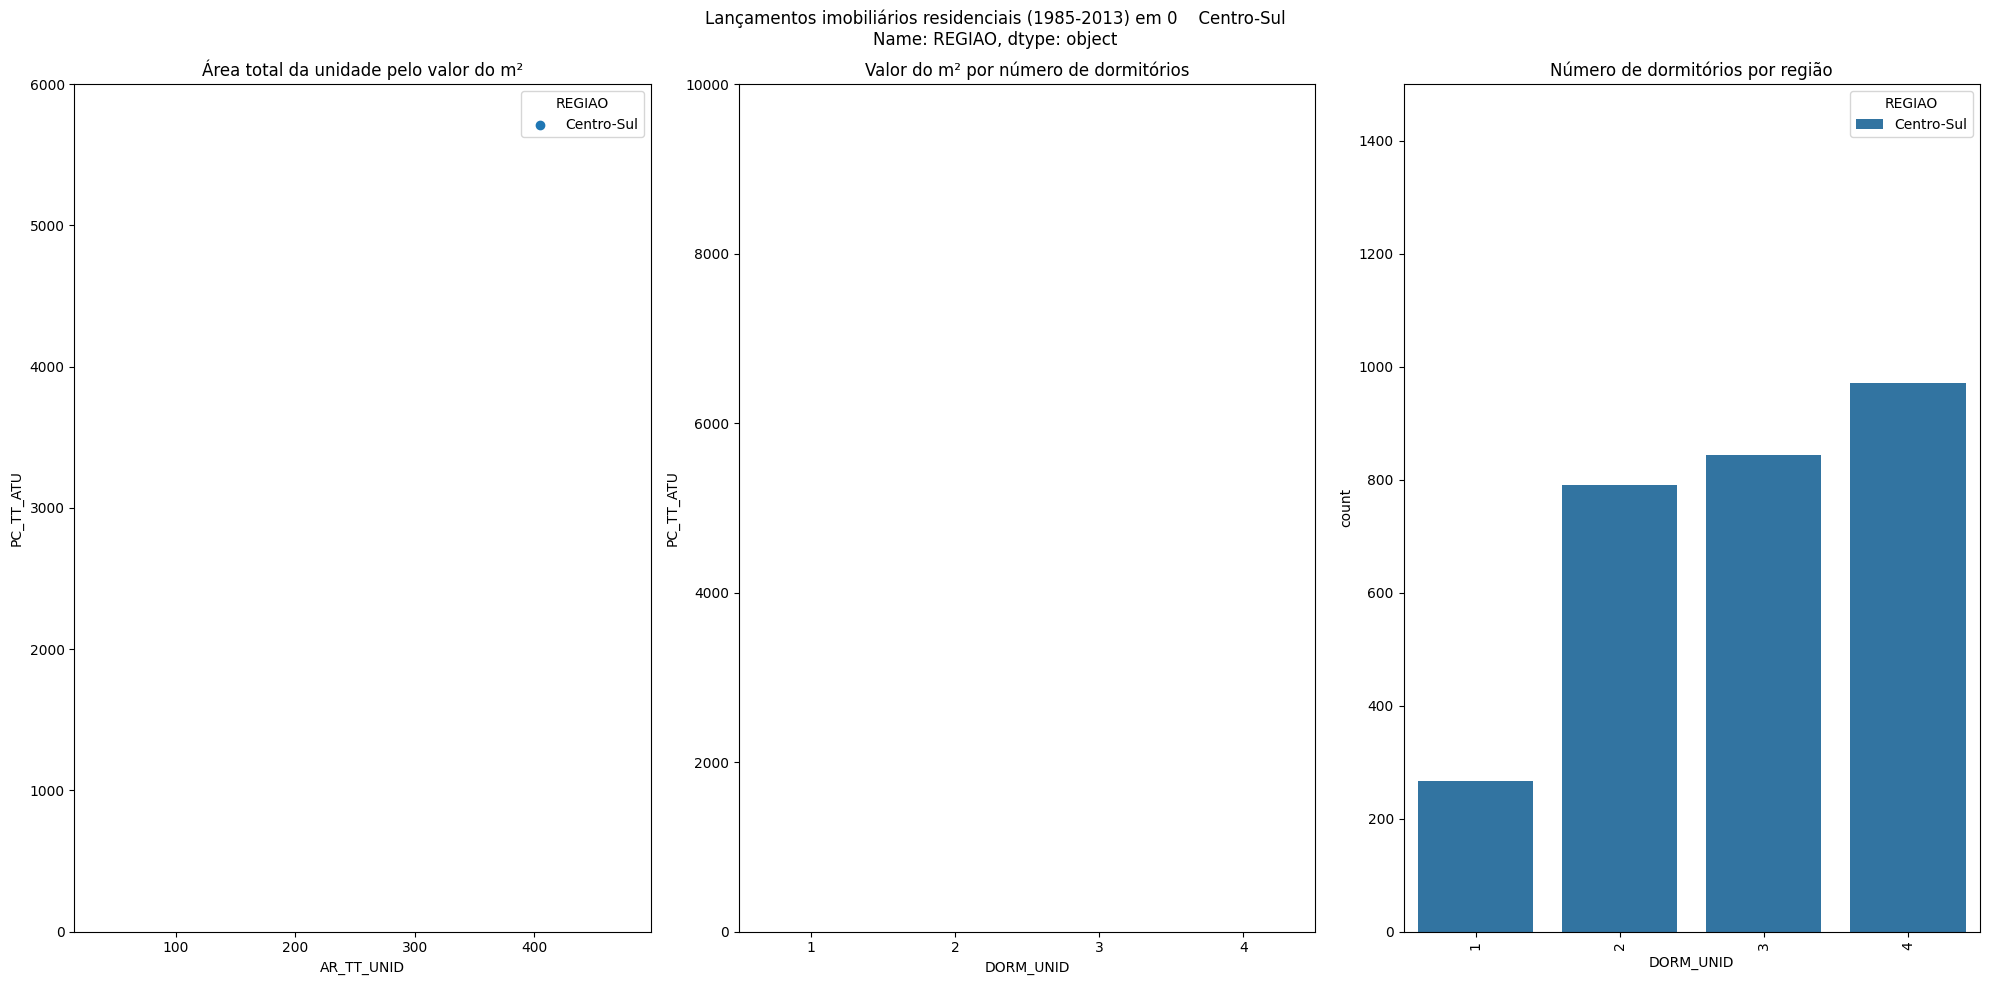

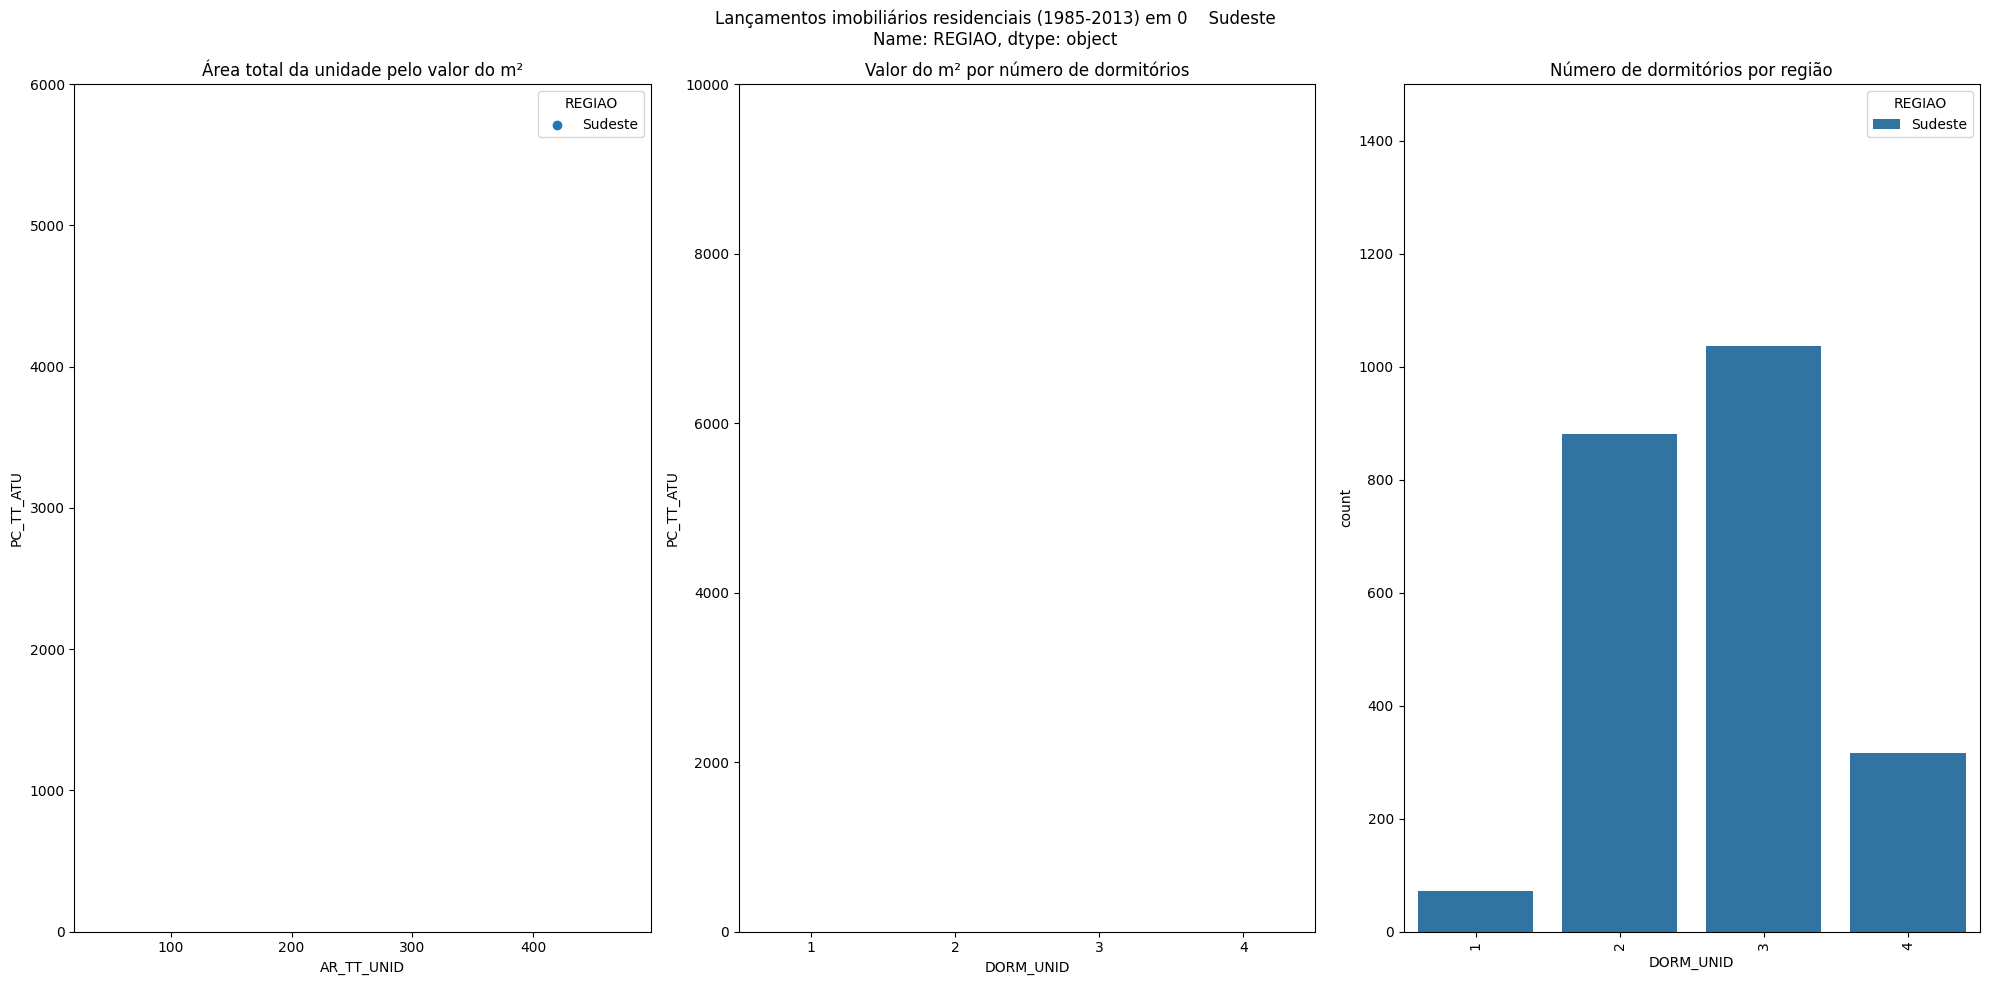

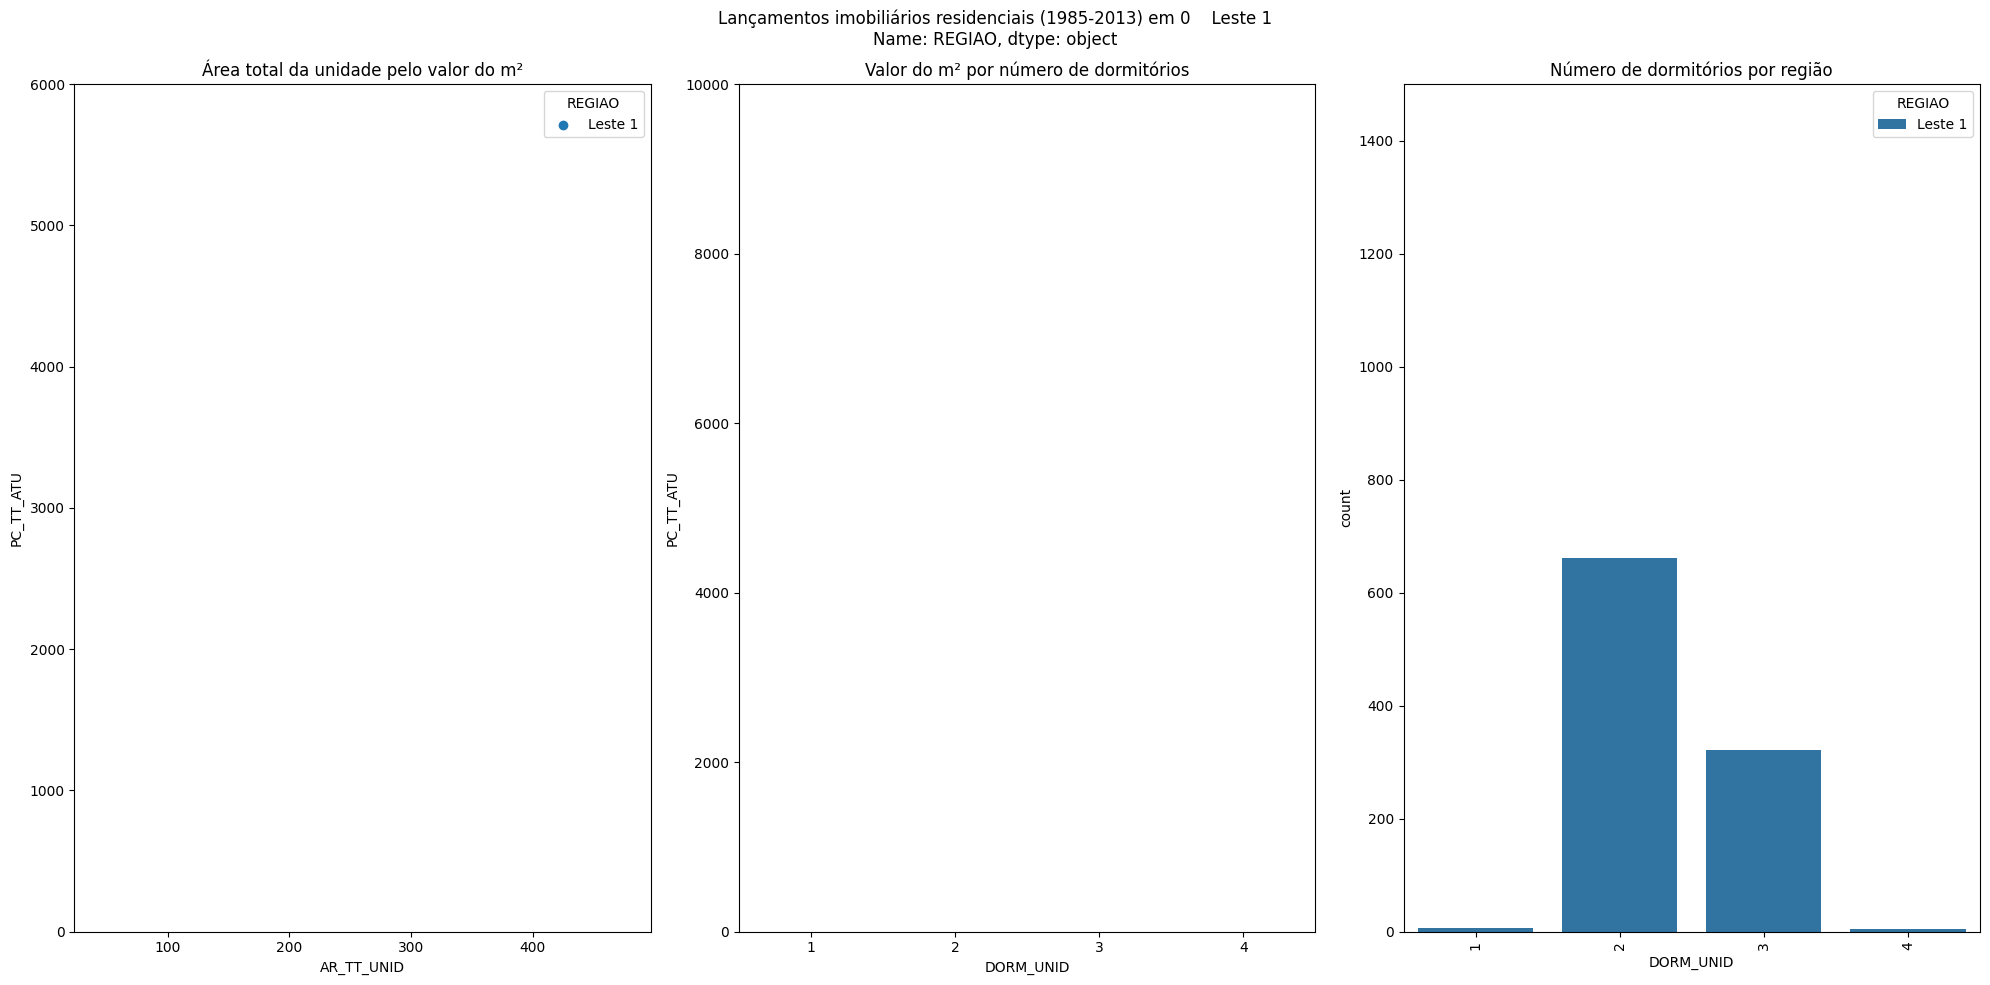

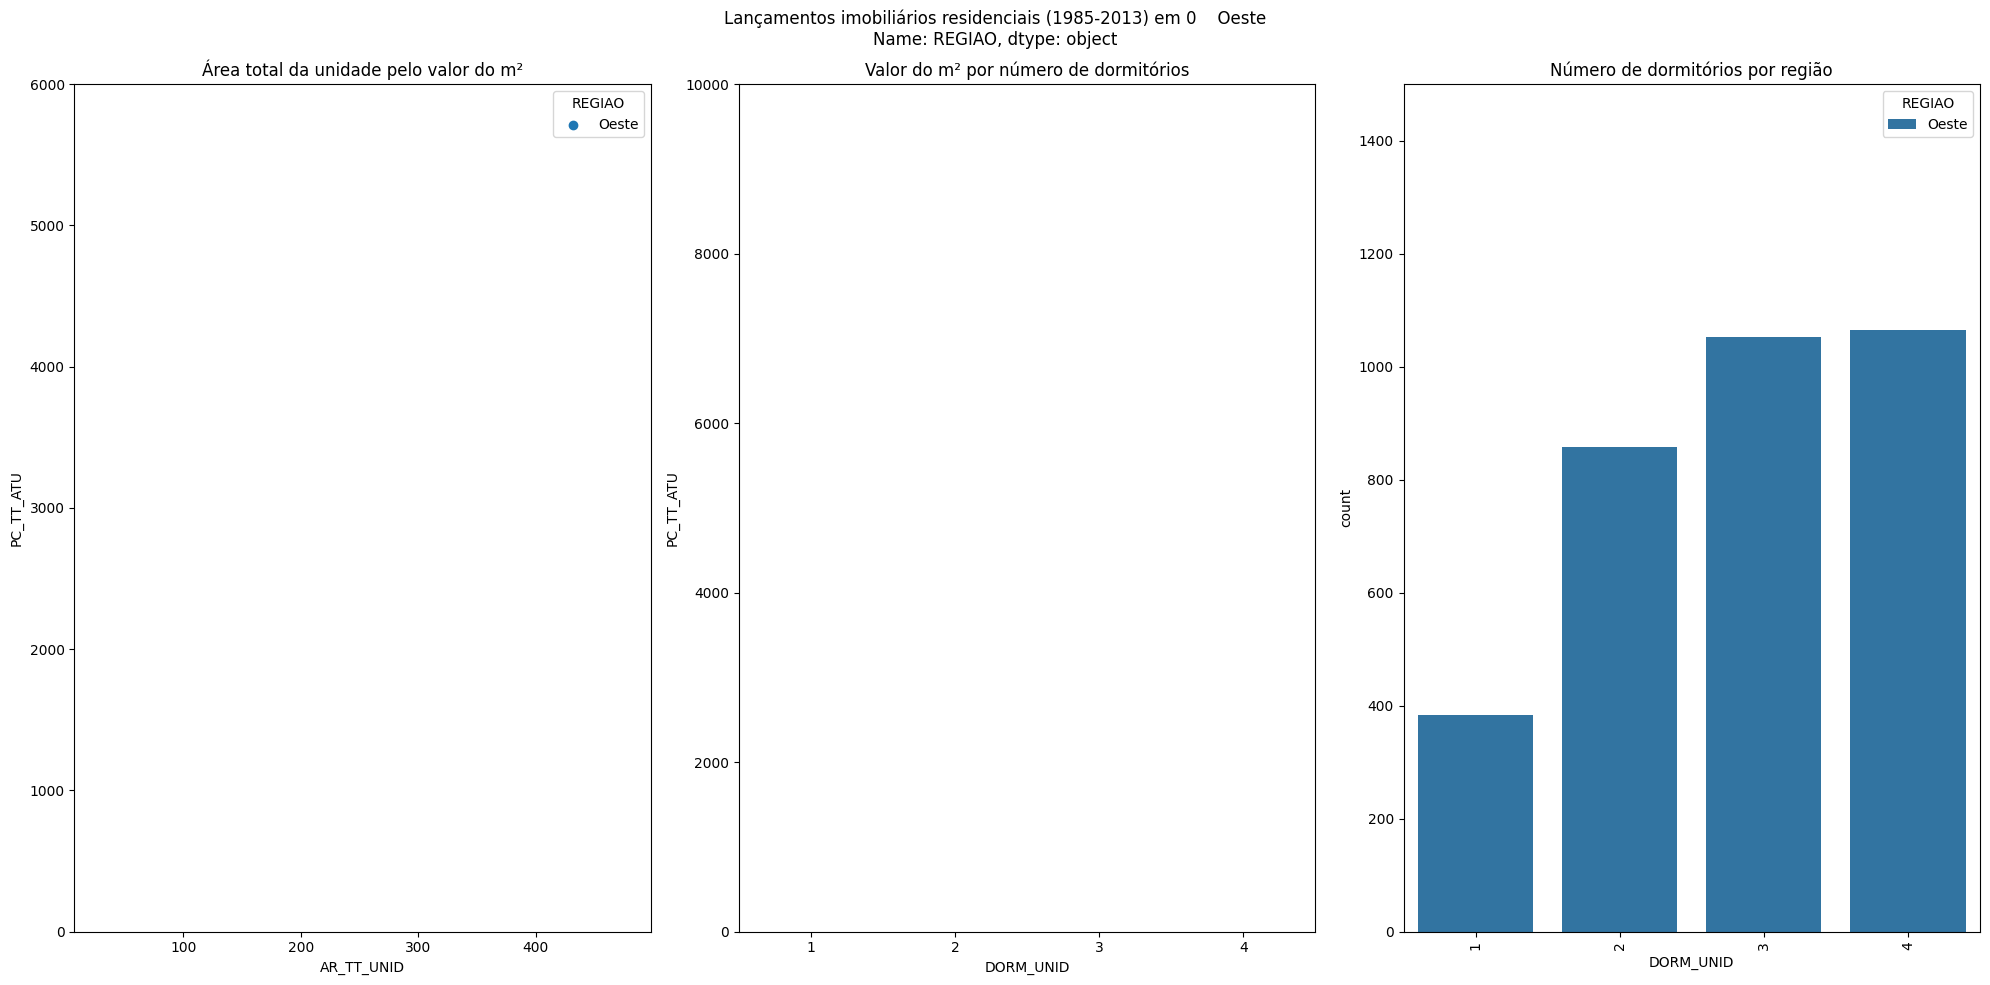

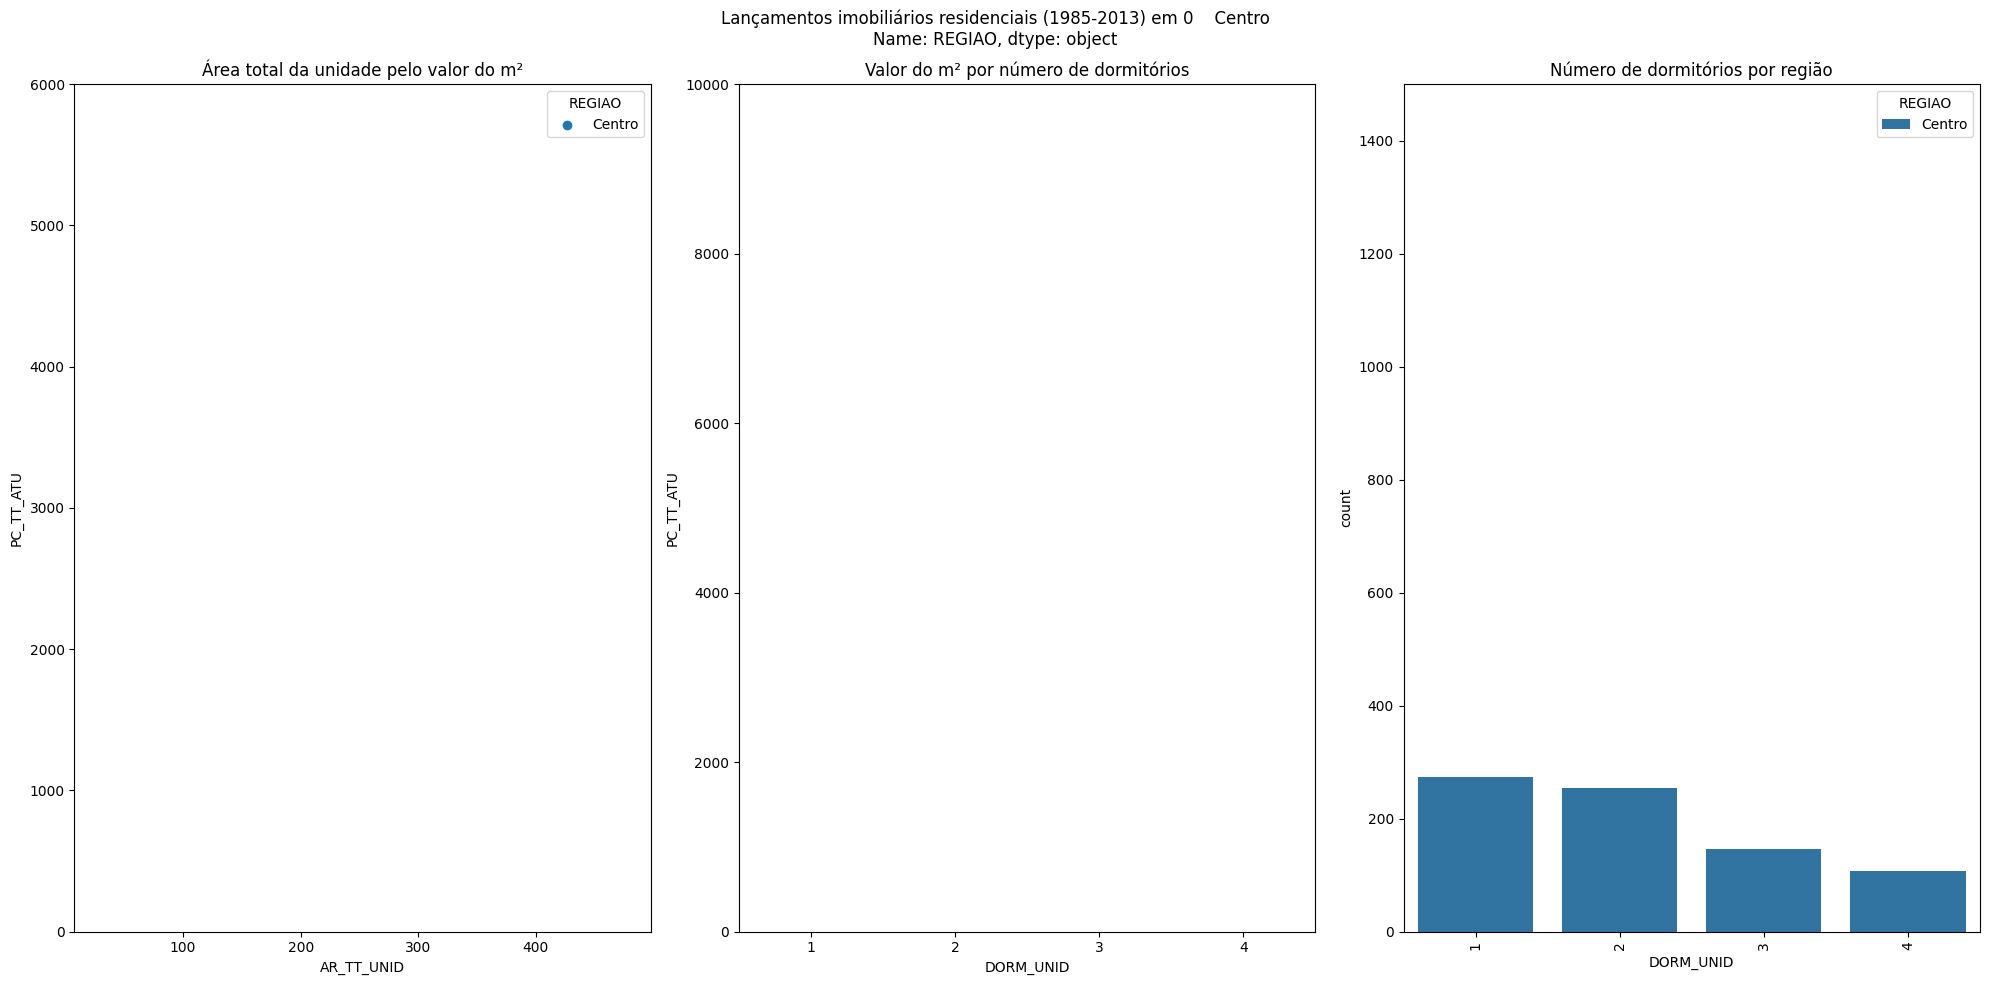

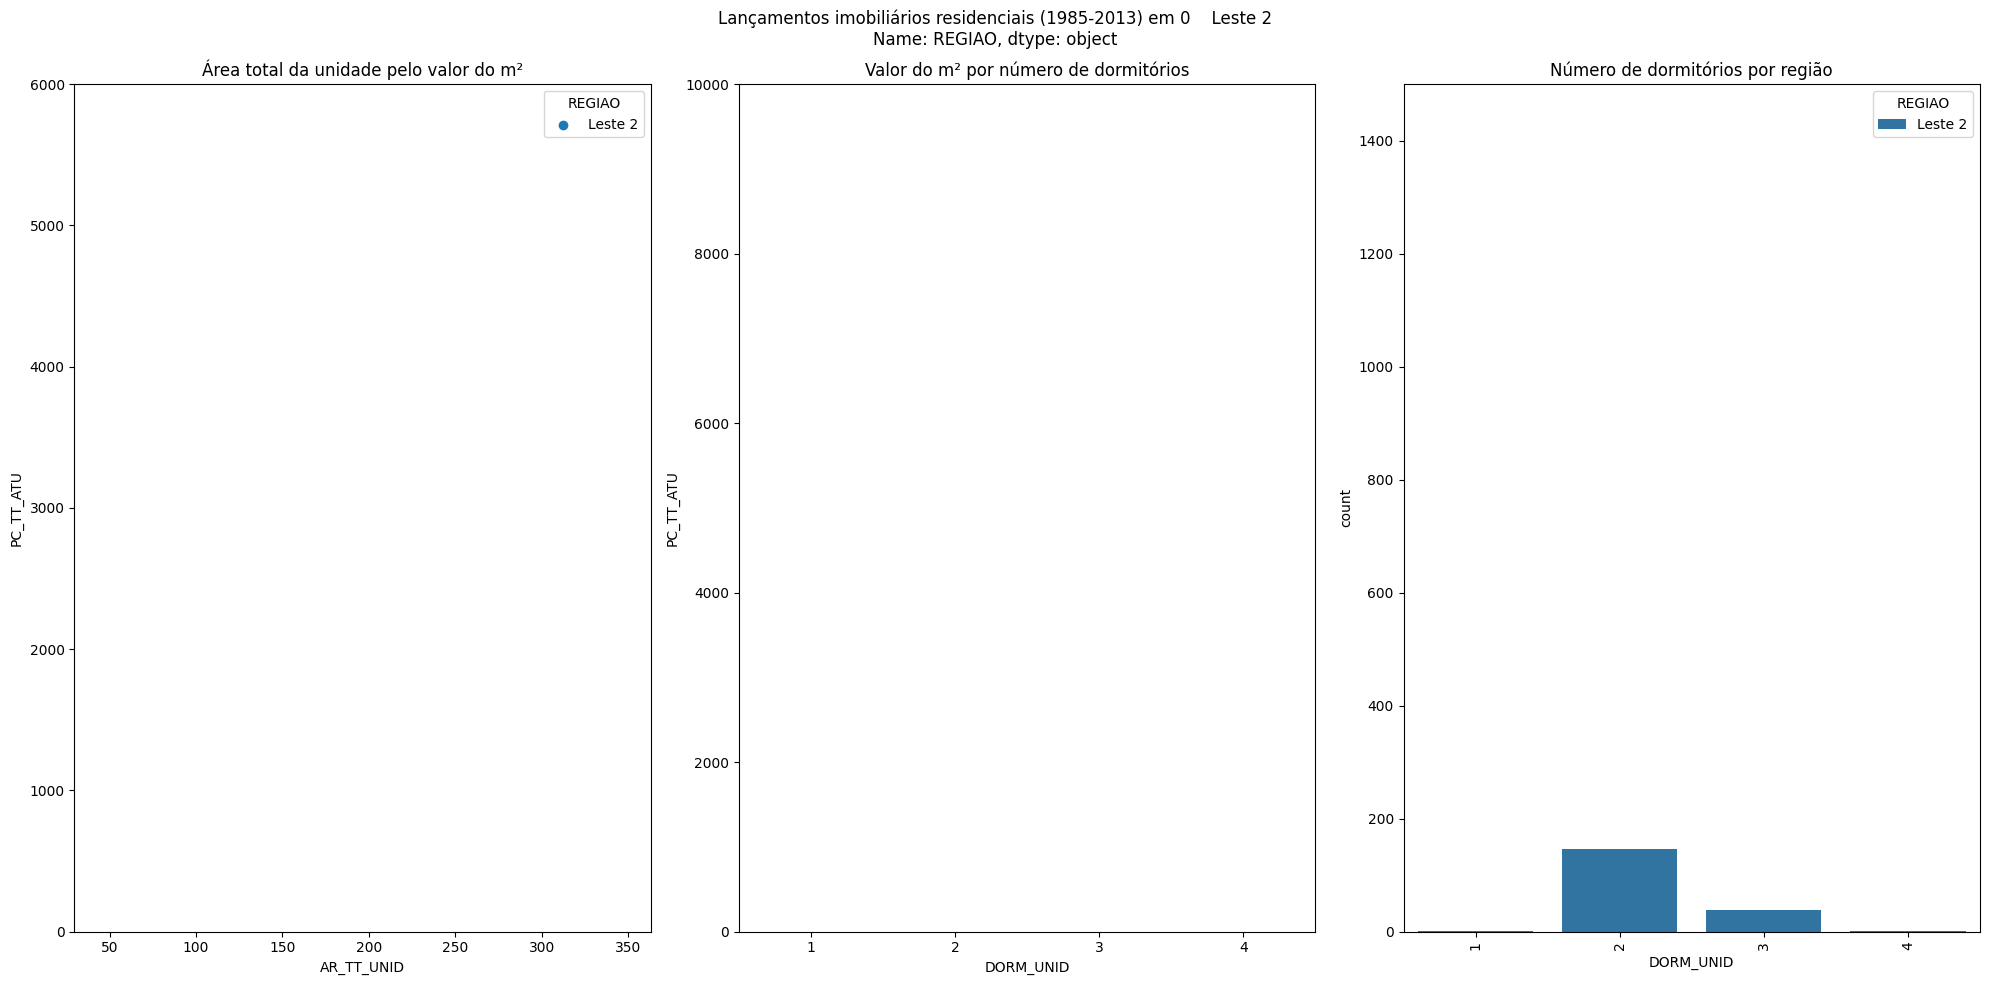

In [148]:
m2_dorm_regiao([df_sul, df_noroeste, df_nordeste, df_centrosul, df_sudeste, df_leste1, df_oeste, df_centro, df_leste2])

<h5>A renda do responsável é muito distinta em cada região, as regiões com maiores números de empreendimentos também são as com empreendimentos mais caros e as que concentram as maiores rendas. As regiões com as menores rendas possuem poucos lançamentos imobiliários</h5>

<AxesSubplot: xlabel='REGIAO', ylabel='RENRESP10'>

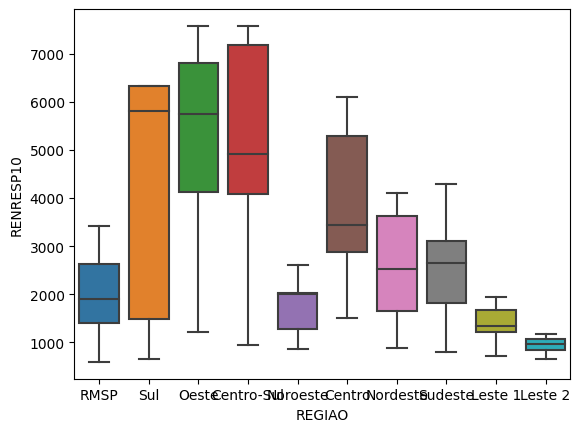

In [149]:
sns.boxplot(y='RENRESP10', data=df, x='REGIAO')

<h4>3.2 Analisando os empreendimentos no tempo</h4>
<h5>Em um geral, o número de lançamentos imobiliários cresceu entre 1985 e 2013, mas as unidades se tornaram consideravelmente menores e com um número menor de quartos, principalmente a partir de 2008. O preço médio do m² foi o menor registrado ao longo da década de 2000, mas tem retomada de crescimento e tendência de ascensão começando em 2010</h5>

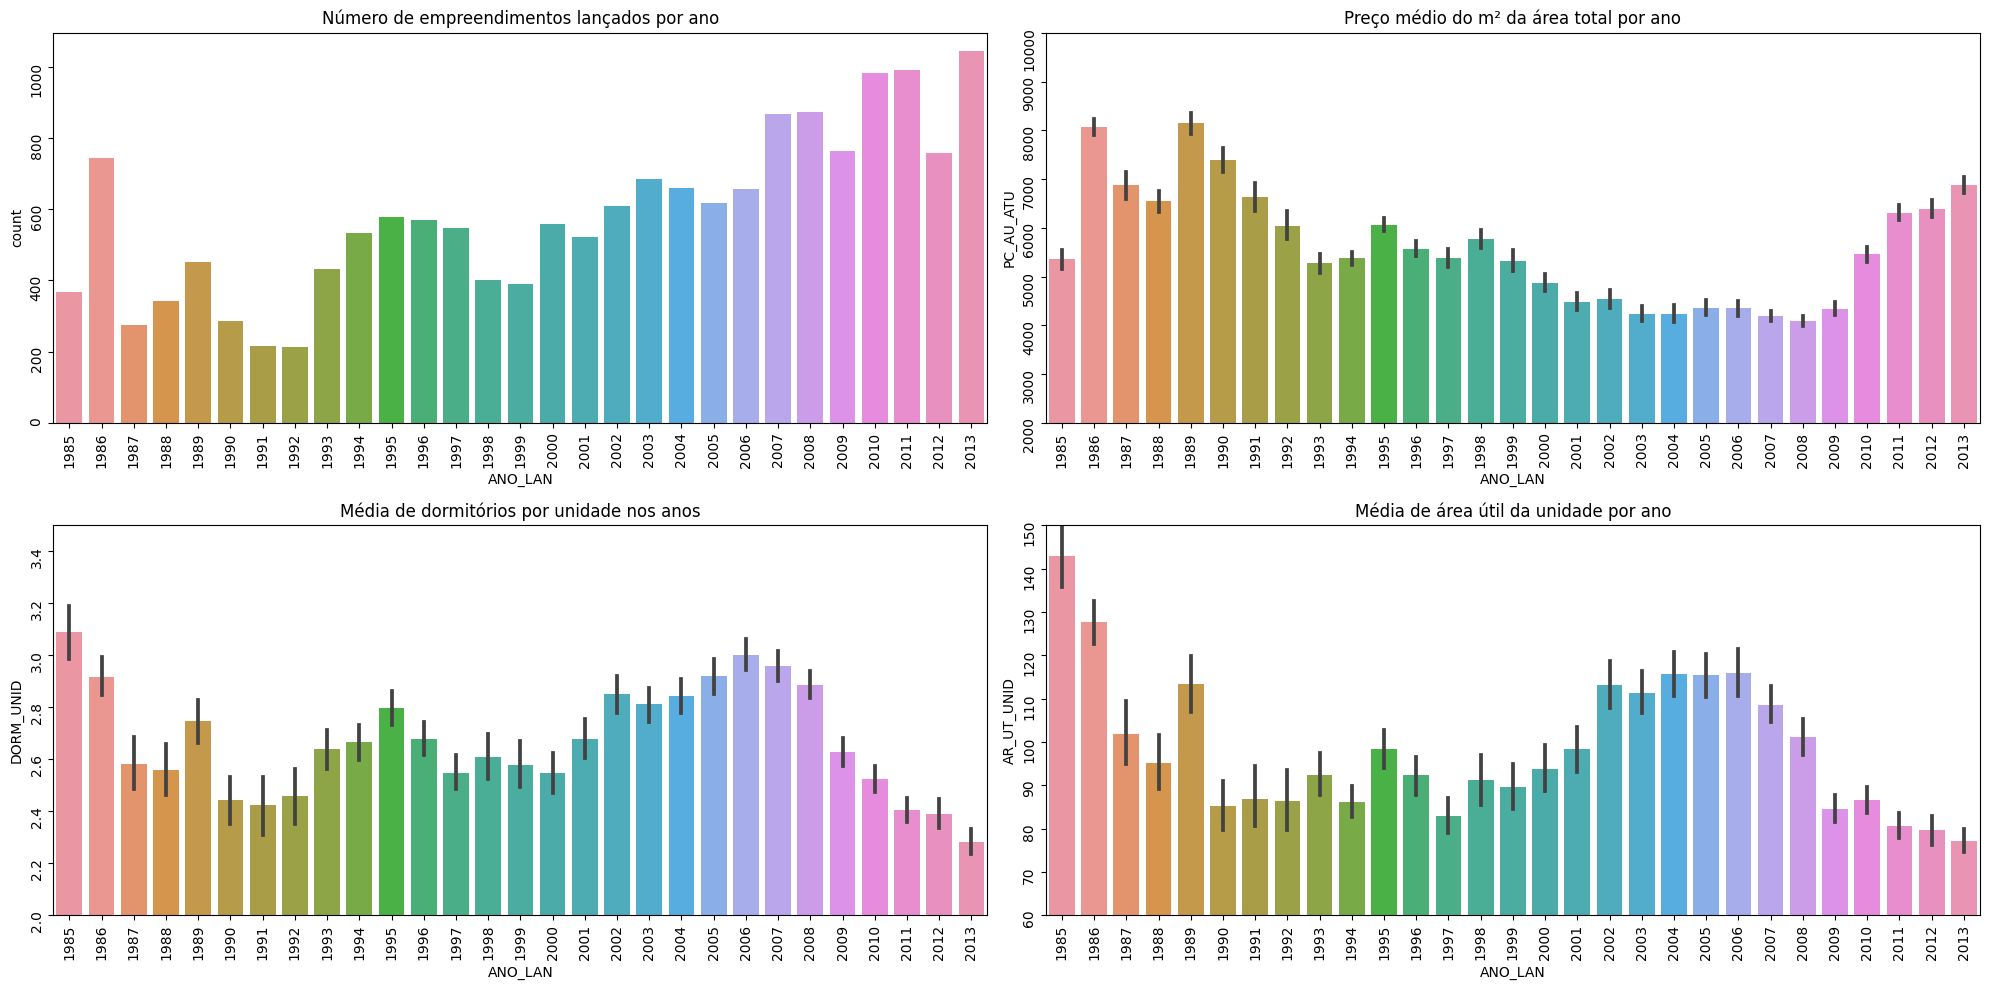

In [189]:
fig, axs = plt.subplots(figsize=(20,10), nrows=2, ncols=2)
emp_ano = sns.countplot(data=df.groupby(df['ANO_LAN']).count(), x=df['ANO_LAN'], ax=axs[0,0])
pc_m2_ano = sns.barplot(y=df['PC_AU_ATU'], x=df['ANO_LAN'], data=df.groupby(df['ANO_LAN']).mean(), ax=axs[0,1])
dorm_ano = sns.barplot(y=df['DORM_UNID'], x=df['ANO_LAN'], data=df.groupby(df['ANO_LAN']).mean(), ax=axs[1,0])
area_util_ano = sns.barplot(y=df['AR_UT_UNID'], x=df['ANO_LAN'], data=df.groupby(df['ANO_LAN']).mean(), ax=axs[1,1])

emp_ano.tick_params(labelrotation = 90)
pc_m2_ano.tick_params(labelrotation = 90)
dorm_ano.tick_params(labelrotation = 90)
area_util_ano.tick_params(labelrotation = 90)

pc_m2_ano.set_ylim(2000,10000)
dorm_ano.set_ylim(2,3.5)
area_util_ano.set_ylim(60,150)

emp_ano.set_title('Número de empreendimentos lançados por ano')
pc_m2_ano.set_title('Preço médio do m² da área total por ano')
dorm_ano.set_title('Média de dormitórios por unidade nos anos')
area_util_ano.set_title('Média de área útil da unidade por ano')

plt.tight_layout()


<h3>3.3 Correlações com características do entorno</h3>

In [151]:
def plot_relacao_censo(dataframe, variaveis, i=0):
    total_plots = len(variaveis)
    fig = plt.figure(figsize=(15,40), facecolor='white')
    #fig.subplots_adjust(hspace=0.6, wspace=0.3)

    for var in variaveis:
        ax = fig.add_subplot(total_plots, 2, i+1)
        sns.scatterplot(x=var, y=v_resposta, data=dataframe, ax=ax, color='#435058')
        i += 1
        plt.xlim(0, dataframe[var].quantile(0.99))

In [152]:
df['PERC_ALUGADOS'].quantile([0.01, 0.99])

0.01     2.631579
0.99    43.925236
Name: PERC_ALUGADOS, dtype: float64

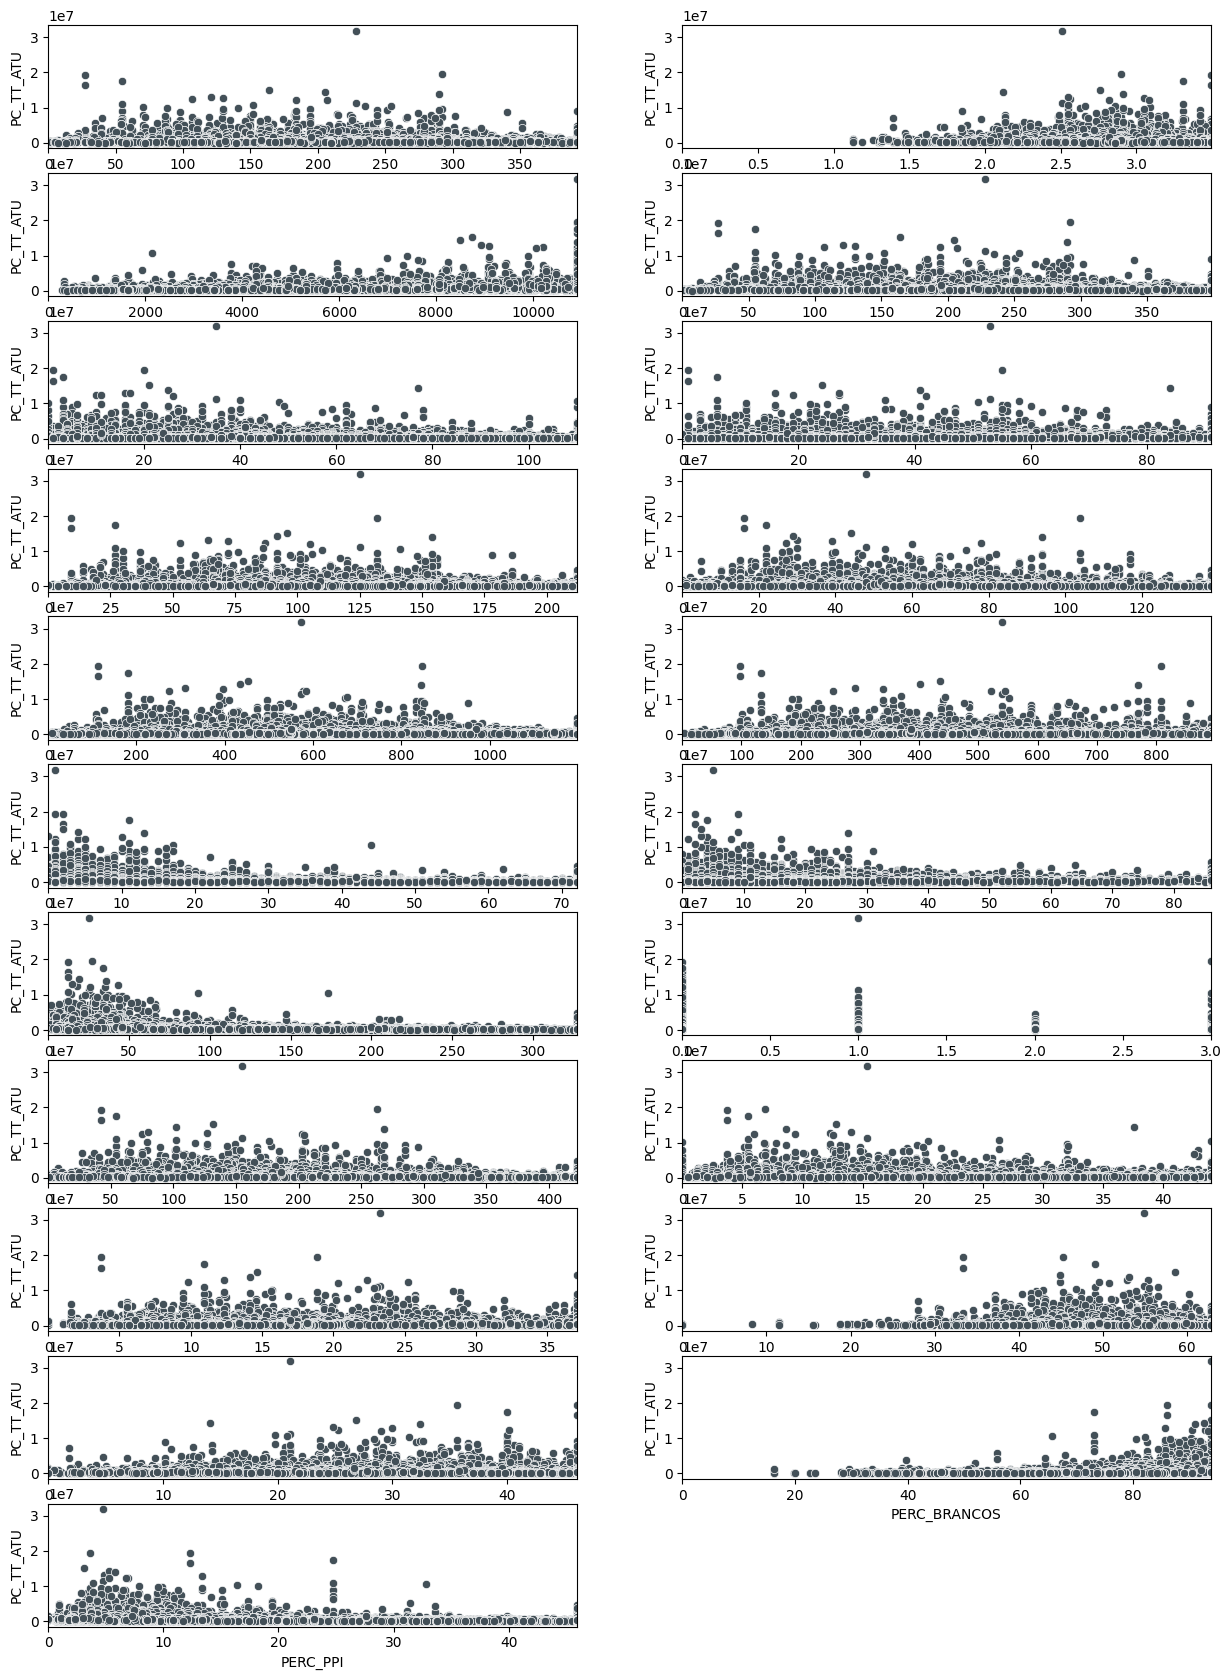

In [153]:
plot_relacao_censo(df, v_censo)

In [154]:
df['AGENTE'].value_counts()

PRIVADO           8877
SEM INFORMAÇÃO    8058
Name: AGENTE, dtype: Int64

In [155]:
df['INCORPORAD'].value_counts()

iNCORPORADORA MENOR       13393
MAIORES INCORPORADORAS     3542
Name: INCORPORAD, dtype: Int64

In [305]:
df.to_csv('Base_EMBRAESP_Trabalhada.csv')